In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from joblib import Parallel, delayed

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

# 연습

### dlinear model

In [ ]:
class moving_avg(torch.nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
    	  # [BATCH SIZE, SEQ_LEN, CHANNEL]
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x # [BATCH SIZE, SEQ_LEN, CHANNEL]

class series_decomp(torch.nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size

        # Decompsition Kernel Size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size


        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        trend_init, seasonal_init = self.decompsition(x)
        # seasonal_init: [Batch, Input length, Channel]
        # trend_init: [Batch, Input length, Channel]
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        # seasonal_init: [Batch, Channel, Input length]
        # trend_init: [Batch, Channel, Input length]

        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

### data load

In [ ]:
window_size = 30
forcast_size= 10
batch_size = 32

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/time_series confer/data/train.csv',encoding='utf-8').groupby('소분류').sum()
data = data.drop(columns=['ID'], axis=0)

In [ ]:
def time_slide_df(df, window_size, forcast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size):
        x = df_[idx:idx+window_size].reshape(window_size, 1)
        y = df_[idx+window_size:idx+window_size+forcast_size]
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.T).T

combined_X = []
combined_y = []

for group_data in data:
  sales_data = group_data.flatten()
  X, y = time_slide_df(sales_data, window_size, forcast_size) #length = 30
  combined_X.append(X)
  combined_y.append(y)


## 개별
## group_data = data
## sales_data = group_data.flatten()
## X, y = time_slide_df(sales_data, window_size, forcast_size) #length = 30
## combined_X.append(X)
## combined_y.append(y)

In [ ]:
combined_X = np.concatenate(combined_X, axis=0)
combined_y = np.concatenate(combined_y, axis=0)

# 스케일링된 데이터로 데이터셋 재구성
train_size = int(0.8 * len(combined_X))
X_train, X_test = combined_X[:train_size], combined_X[train_size:]
y_train, y_test = combined_y[:train_size], combined_y[train_size:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17765, 30, 1), (4442, 30, 1), (17765, 10), (4442, 10))

In [ ]:
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# PyTorch 데이터셋 및 데이터 로더
train_dataset = Data(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
test_dataset = Data(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
epoch = 100
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, Model Save".format(valid_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))

  1%|          | 1/100 [00:01<02:06,  1.28s/it]

valid_loss=0.011, Model Save
epoch = 1, train_loss : 0.018, valid_loss : 0.011


  2%|▏         | 2/100 [00:02<01:54,  1.17s/it]

valid_loss=0.007, Model Save
epoch = 2, train_loss : 0.014, valid_loss : 0.007


  3%|▎         | 3/100 [00:03<01:51,  1.15s/it]

valid_loss=0.006, Model Save
epoch = 3, train_loss : 0.014, valid_loss : 0.006


  4%|▍         | 4/100 [00:05<02:06,  1.32s/it]

valid_loss=0.006, Model Save
epoch = 4, train_loss : 0.014, valid_loss : 0.006


  5%|▌         | 5/100 [00:06<02:17,  1.45s/it]

valid_loss=0.006, Model Save
epoch = 5, train_loss : 0.014, valid_loss : 0.006


  6%|▌         | 6/100 [00:08<02:23,  1.53s/it]

valid_loss=0.006, Model Save
epoch = 6, train_loss : 0.014, valid_loss : 0.006


  7%|▋         | 7/100 [00:10<02:24,  1.56s/it]

valid_loss=0.006, Model Save
epoch = 7, train_loss : 0.014, valid_loss : 0.006


  8%|▊         | 8/100 [00:11<02:11,  1.43s/it]

valid_loss=0.006, Model Save
epoch = 8, train_loss : 0.014, valid_loss : 0.006


  9%|▉         | 9/100 [00:12<02:02,  1.35s/it]

valid_loss=0.006, Model Save
epoch = 9, train_loss : 0.014, valid_loss : 0.006


 10%|█         | 10/100 [00:13<01:55,  1.28s/it]

valid_loss=0.006, Model Save
epoch = 10, train_loss : 0.014, valid_loss : 0.006


 11%|█         | 11/100 [00:14<01:49,  1.23s/it]

valid_loss=0.006, Model Save
epoch = 11, train_loss : 0.014, valid_loss : 0.006


 12%|█▏        | 12/100 [00:15<01:45,  1.20s/it]

valid_loss=0.006, Model Save
epoch = 12, train_loss : 0.014, valid_loss : 0.006


 13%|█▎        | 13/100 [00:16<01:42,  1.17s/it]

valid_loss=0.006, Model Save
epoch = 13, train_loss : 0.014, valid_loss : 0.006


 14%|█▍        | 14/100 [00:18<01:40,  1.17s/it]

valid_loss=0.006, Model Save
epoch = 14, train_loss : 0.014, valid_loss : 0.006


 15%|█▌        | 15/100 [00:19<01:52,  1.33s/it]

valid_loss=0.006, Model Save
epoch = 15, train_loss : 0.014, valid_loss : 0.006


 16%|█▌        | 16/100 [00:21<01:55,  1.38s/it]

valid_loss=0.006, Model Save
epoch = 16, train_loss : 0.014, valid_loss : 0.006


 17%|█▋        | 17/100 [00:22<01:59,  1.45s/it]

valid_loss=0.006, Model Save
epoch = 17, train_loss : 0.014, valid_loss : 0.006


 18%|█▊        | 18/100 [00:24<02:02,  1.49s/it]

valid_loss=0.006, Model Save
epoch = 18, train_loss : 0.014, valid_loss : 0.006


 19%|█▉        | 19/100 [00:26<02:04,  1.53s/it]

valid_loss=0.006, Model Save
epoch = 19, train_loss : 0.014, valid_loss : 0.006


 20%|██        | 20/100 [00:27<01:53,  1.42s/it]

valid_loss=0.006, Model Save
epoch = 20, train_loss : 0.014, valid_loss : 0.006


 21%|██        | 21/100 [00:28<01:46,  1.35s/it]

valid_loss=0.006, Model Save
epoch = 21, train_loss : 0.014, valid_loss : 0.006


 22%|██▏       | 22/100 [00:29<01:40,  1.28s/it]

valid_loss=0.006, Model Save
epoch = 22, train_loss : 0.014, valid_loss : 0.006


 23%|██▎       | 23/100 [00:30<01:35,  1.25s/it]

valid_loss=0.006, Model Save
epoch = 23, train_loss : 0.014, valid_loss : 0.006


 24%|██▍       | 24/100 [00:31<01:32,  1.22s/it]

valid_loss=0.006, Model Save
epoch = 24, train_loss : 0.014, valid_loss : 0.006


 25%|██▌       | 25/100 [00:32<01:29,  1.20s/it]

valid_loss=0.006, Model Save
epoch = 25, train_loss : 0.014, valid_loss : 0.006


 26%|██▌       | 26/100 [00:34<01:26,  1.16s/it]

valid_loss=0.006, Model Save
epoch = 26, train_loss : 0.014, valid_loss : 0.006


 27%|██▋       | 27/100 [00:35<01:23,  1.14s/it]

valid_loss=0.006, Model Save
epoch = 27, train_loss : 0.014, valid_loss : 0.006


 28%|██▊       | 28/100 [00:36<01:23,  1.16s/it]

valid_loss=0.006, Model Save
epoch = 28, train_loss : 0.014, valid_loss : 0.006


 29%|██▉       | 29/100 [00:37<01:31,  1.28s/it]

valid_loss=0.006, Model Save
epoch = 29, train_loss : 0.014, valid_loss : 0.006


 30%|███       | 30/100 [00:39<01:35,  1.37s/it]

valid_loss=0.006, Model Save
epoch = 30, train_loss : 0.014, valid_loss : 0.006


 31%|███       | 31/100 [00:41<01:38,  1.42s/it]

valid_loss=0.006, Model Save
epoch = 31, train_loss : 0.014, valid_loss : 0.006


 32%|███▏      | 32/100 [00:42<01:35,  1.40s/it]

valid_loss=0.006, Model Save
epoch = 32, train_loss : 0.014, valid_loss : 0.006


 33%|███▎      | 33/100 [00:43<01:28,  1.32s/it]

valid_loss=0.006, Model Save
epoch = 33, train_loss : 0.014, valid_loss : 0.006


 34%|███▍      | 34/100 [00:44<01:23,  1.26s/it]

valid_loss=0.006, Model Save
epoch = 34, train_loss : 0.014, valid_loss : 0.006


 35%|███▌      | 35/100 [00:45<01:19,  1.22s/it]

valid_loss=0.006, Model Save
epoch = 35, train_loss : 0.014, valid_loss : 0.006


 36%|███▌      | 36/100 [00:46<01:16,  1.20s/it]

valid_loss=0.006, Model Save
epoch = 36, train_loss : 0.014, valid_loss : 0.006


 37%|███▋      | 37/100 [00:48<01:14,  1.19s/it]

valid_loss=0.006, Model Save
epoch = 37, train_loss : 0.014, valid_loss : 0.006


 38%|███▊      | 38/100 [00:49<01:12,  1.17s/it]

valid_loss=0.006, Model Save
epoch = 38, train_loss : 0.014, valid_loss : 0.006


 39%|███▉      | 39/100 [00:50<01:11,  1.17s/it]

valid_loss=0.006, Model Save
epoch = 39, train_loss : 0.014, valid_loss : 0.006


 40%|████      | 40/100 [00:51<01:09,  1.15s/it]

valid_loss=0.006, Model Save
epoch = 40, train_loss : 0.014, valid_loss : 0.006


 41%|████      | 41/100 [00:53<01:14,  1.27s/it]

valid_loss=0.006, Model Save
epoch = 41, train_loss : 0.014, valid_loss : 0.006


 42%|████▏     | 42/100 [00:54<01:19,  1.38s/it]

valid_loss=0.006, Model Save
epoch = 42, train_loss : 0.014, valid_loss : 0.006


 43%|████▎     | 43/100 [00:56<01:23,  1.47s/it]

epoch = 43, train_loss : 0.014, valid_loss : 0.006


 44%|████▍     | 44/100 [00:58<01:26,  1.54s/it]

valid_loss=0.006, Model Save
epoch = 44, train_loss : 0.014, valid_loss : 0.006


 45%|████▌     | 45/100 [00:59<01:18,  1.42s/it]

valid_loss=0.006, Model Save
epoch = 45, train_loss : 0.014, valid_loss : 0.006


 46%|████▌     | 46/100 [01:00<01:12,  1.35s/it]

valid_loss=0.006, Model Save
epoch = 46, train_loss : 0.014, valid_loss : 0.006


 47%|████▋     | 47/100 [01:01<01:08,  1.29s/it]

valid_loss=0.006, Model Save
epoch = 47, train_loss : 0.014, valid_loss : 0.006


 48%|████▊     | 48/100 [01:02<01:05,  1.25s/it]

valid_loss=0.006, Model Save
epoch = 48, train_loss : 0.014, valid_loss : 0.006


 49%|████▉     | 49/100 [01:03<01:02,  1.22s/it]

epoch = 49, train_loss : 0.014, valid_loss : 0.006


 50%|█████     | 50/100 [01:05<01:00,  1.20s/it]

epoch = 50, train_loss : 0.014, valid_loss : 0.006


 51%|█████     | 51/100 [01:06<00:57,  1.18s/it]

epoch = 51, train_loss : 0.014, valid_loss : 0.006


 52%|█████▏    | 52/100 [01:07<00:56,  1.17s/it]

epoch = 52, train_loss : 0.014, valid_loss : 0.006


 53%|█████▎    | 53/100 [01:08<00:56,  1.20s/it]

epoch = 53, train_loss : 0.014, valid_loss : 0.006


 54%|█████▍    | 54/100 [01:10<01:00,  1.31s/it]

valid_loss=0.006, Model Save
epoch = 54, train_loss : 0.014, valid_loss : 0.006


 55%|█████▌    | 55/100 [01:11<01:02,  1.40s/it]

valid_loss=0.006, Model Save
epoch = 55, train_loss : 0.014, valid_loss : 0.006


 56%|█████▌    | 56/100 [01:13<01:04,  1.47s/it]

epoch = 56, train_loss : 0.014, valid_loss : 0.006


 57%|█████▋    | 57/100 [01:14<01:00,  1.41s/it]

epoch = 57, train_loss : 0.014, valid_loss : 0.006


 58%|█████▊    | 58/100 [01:15<00:56,  1.34s/it]

epoch = 58, train_loss : 0.014, valid_loss : 0.006


 59%|█████▉    | 59/100 [01:16<00:51,  1.27s/it]

epoch = 59, train_loss : 0.014, valid_loss : 0.006


 60%|██████    | 60/100 [01:18<00:49,  1.23s/it]

epoch = 60, train_loss : 0.014, valid_loss : 0.006


 61%|██████    | 61/100 [01:19<00:46,  1.19s/it]

epoch = 61, train_loss : 0.014, valid_loss : 0.006


 62%|██████▏   | 62/100 [01:20<00:44,  1.17s/it]

epoch = 62, train_loss : 0.014, valid_loss : 0.006


 63%|██████▎   | 63/100 [01:21<00:42,  1.16s/it]

epoch = 63, train_loss : 0.014, valid_loss : 0.006


 64%|██████▍   | 64/100 [01:22<00:41,  1.14s/it]

epoch = 64, train_loss : 0.014, valid_loss : 0.006


 65%|██████▌   | 65/100 [01:23<00:39,  1.14s/it]

epoch = 65, train_loss : 0.014, valid_loss : 0.006


 66%|██████▌   | 66/100 [01:25<00:43,  1.28s/it]

epoch = 66, train_loss : 0.014, valid_loss : 0.006


 67%|██████▋   | 67/100 [01:26<00:45,  1.37s/it]

epoch = 67, train_loss : 0.014, valid_loss : 0.006


 68%|██████▊   | 68/100 [01:28<00:45,  1.43s/it]

epoch = 68, train_loss : 0.014, valid_loss : 0.006


 69%|██████▉   | 69/100 [01:29<00:44,  1.43s/it]

epoch = 69, train_loss : 0.014, valid_loss : 0.006


 70%|███████   | 70/100 [01:30<00:40,  1.34s/it]

epoch = 70, train_loss : 0.014, valid_loss : 0.006


 71%|███████   | 71/100 [01:32<00:36,  1.27s/it]

epoch = 71, train_loss : 0.014, valid_loss : 0.006


 72%|███████▏  | 72/100 [01:33<00:34,  1.23s/it]

epoch = 72, train_loss : 0.014, valid_loss : 0.006


 73%|███████▎  | 73/100 [01:34<00:32,  1.21s/it]

epoch = 73, train_loss : 0.014, valid_loss : 0.006


 74%|███████▍  | 74/100 [01:35<00:31,  1.20s/it]

epoch = 74, train_loss : 0.014, valid_loss : 0.006


 75%|███████▌  | 75/100 [01:36<00:30,  1.20s/it]

valid_loss=0.006, Model Save
epoch = 75, train_loss : 0.014, valid_loss : 0.006


 76%|███████▌  | 76/100 [01:37<00:28,  1.19s/it]

epoch = 76, train_loss : 0.014, valid_loss : 0.006


 77%|███████▋  | 77/100 [01:39<00:27,  1.19s/it]

epoch = 77, train_loss : 0.014, valid_loss : 0.006


 78%|███████▊  | 78/100 [01:40<00:28,  1.28s/it]

epoch = 78, train_loss : 0.014, valid_loss : 0.006


 79%|███████▉  | 79/100 [01:42<00:29,  1.40s/it]

epoch = 79, train_loss : 0.014, valid_loss : 0.006


 80%|████████  | 80/100 [01:43<00:29,  1.46s/it]

epoch = 80, train_loss : 0.014, valid_loss : 0.006


 81%|████████  | 81/100 [01:45<00:28,  1.52s/it]

epoch = 81, train_loss : 0.014, valid_loss : 0.006


 82%|████████▏ | 82/100 [01:46<00:25,  1.42s/it]

epoch = 82, train_loss : 0.014, valid_loss : 0.006


 83%|████████▎ | 83/100 [01:47<00:22,  1.34s/it]

epoch = 83, train_loss : 0.014, valid_loss : 0.006


 84%|████████▍ | 84/100 [01:49<00:23,  1.45s/it]

epoch = 84, train_loss : 0.014, valid_loss : 0.006


 85%|████████▌ | 85/100 [01:51<00:22,  1.52s/it]

epoch = 85, train_loss : 0.014, valid_loss : 0.006


 86%|████████▌ | 86/100 [01:52<00:19,  1.41s/it]

epoch = 86, train_loss : 0.014, valid_loss : 0.006


 87%|████████▋ | 87/100 [01:53<00:17,  1.36s/it]

epoch = 87, train_loss : 0.014, valid_loss : 0.006


 88%|████████▊ | 88/100 [01:54<00:15,  1.30s/it]

epoch = 88, train_loss : 0.014, valid_loss : 0.006


 89%|████████▉ | 89/100 [01:56<00:14,  1.34s/it]

epoch = 89, train_loss : 0.014, valid_loss : 0.006


 90%|█████████ | 90/100 [01:57<00:14,  1.44s/it]

epoch = 90, train_loss : 0.014, valid_loss : 0.006


 91%|█████████ | 91/100 [01:59<00:13,  1.49s/it]

epoch = 91, train_loss : 0.014, valid_loss : 0.006


 92%|█████████▏| 92/100 [02:01<00:12,  1.52s/it]

epoch = 92, train_loss : 0.014, valid_loss : 0.006


 93%|█████████▎| 93/100 [02:02<00:10,  1.43s/it]

epoch = 93, train_loss : 0.014, valid_loss : 0.006


 94%|█████████▍| 94/100 [02:03<00:08,  1.34s/it]

epoch = 94, train_loss : 0.014, valid_loss : 0.006


 95%|█████████▌| 95/100 [02:04<00:06,  1.27s/it]

epoch = 95, train_loss : 0.014, valid_loss : 0.006


 96%|█████████▌| 96/100 [02:05<00:04,  1.24s/it]

epoch = 96, train_loss : 0.014, valid_loss : 0.006


 97%|█████████▋| 97/100 [02:06<00:03,  1.23s/it]

epoch = 97, train_loss : 0.014, valid_loss : 0.006


 98%|█████████▊| 98/100 [02:08<00:02,  1.21s/it]

epoch = 98, train_loss : 0.014, valid_loss : 0.006


 99%|█████████▉| 99/100 [02:09<00:01,  1.19s/it]

epoch = 99, train_loss : 0.014, valid_loss : 0.006


100%|██████████| 100/100 [02:10<00:00,  1.30s/it]

epoch = 100, train_loss : 0.014, valid_loss : 0.006


In [ ]:
import matplotlib.pyplot as plt
# 임의의 훈련 샘플 선택 (여기서는 마지막 샘플을 사용)
sample_seq, sample_label = test_dataset[-400]

torch_tensor = torch.from_numpy(sample_seq)

# unsqueeze 메서드를 사용하여 차원 추가
torch_tensor = torch_tensor.unsqueeze(0)

DLinear_model.eval()
with torch.no_grad():
    sample_pred= DLinear_model(torch_tensor)  # 배치 차원 추가

# 실제 값과 예측 값을 numpy 배열로 변환
sample_seq = sample_seq
sample_label = sample_label
sample_pred = sample_pred.numpy()

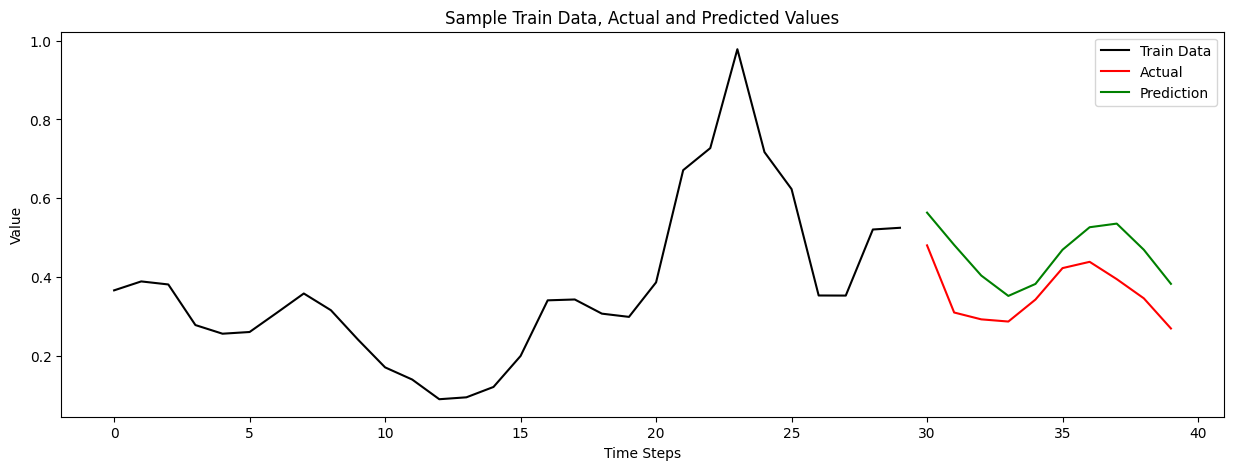

In [ ]:
# 시각화
plt.figure(figsize=(15, 5))

# 훈련 데이터 부분 (노란색)
plt.plot(np.arange(len(sample_seq)), sample_seq, label='Train Data', color='black')

# 실제 레이블 부분 (빨간색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
actual_indices = np.arange(len(sample_seq), len(sample_seq) + len(sample_label))
plt.plot(actual_indices, sample_label, label='Actual', color='red')

# 예측 부분 (초록색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
pred_indices = np.arange(len(sample_seq), len(sample_seq) + len(sample_pred[0]))
plt.plot(pred_indices, sample_pred[0], label='Prediction', color='green')

plt.title('Sample Train Data, Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

In [ ]:
## lstm보다 loss가 낮게 나오긴 함. 주기성을 좀 타는 느낌이라 살짝 다른 느낌으로 나타나는듯? 나도 정확하진 않음

## 대분류로

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/train.csv',encoding='utf-8').groupby('대분류').sum()
df = df.drop(columns=['ID'], axis=0)
df.head(5)

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
대분류,,,,,,,,,,,,,,,,,,,,,
B002-C001-0001,84536,73870,57336,54769,66988,75390,85298,103458,109806,102022,...,2481,2580,2615,45184,37781,37409,37161,31807,41884,55732
B002-C001-0002,113619,84433,78236,82917,104607,117228,113833,95617,96289,85339,...,4424,4184,3985,98177,101582,73205,68867,73300,92846,96875
B002-C001-0003,31,33,17,16,19,24,24,32,33,32,...,568,628,610,1943,2036,2109,1361,1633,2067,1957
B002-C001-0004,4,1,3,9,12,10,13,15,11,8,...,47,49,51,102,98,91,75,93,118,132
B002-C001-0005,6592,7219,7626,8333,6409,5755,6339,4788,5626,4071,...,452,238,266,5520,7393,9639,5721,4007,6736,4697


In [ ]:
def time_slide_df(df, window_size, forcast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size):
        x = df_[idx:idx+window_size].reshape(window_size, 1)
        y = df_[idx+window_size:idx+window_size+forcast_size]
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df.T).T

combined_X = []
combined_y = []

for group_data in df:
  sales_data = group_data.flatten()
  X, y = time_slide_df(sales_data, window_size, forcast_size) #length = 30
  combined_X.append(X)
  combined_y.append(y)


## 개별
## group_data = data
## sales_data = group_data.flatten()
## X, y = time_slide_df(sales_data, window_size, forcast_size) #length = 30
## combined_X.append(X)
## combined_y.append(y)

In [ ]:
combined_X = np.concatenate(combined_X, axis=0)
combined_y = np.concatenate(combined_y, axis=0)

# 스케일링된 데이터로 데이터셋 재구성
train_size = int(0.8 * len(combined_X))
X_train, X_test = combined_X[:train_size], combined_X[train_size:]
y_train, y_test = combined_y[:train_size], combined_y[train_size:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1676, 30, 1), (419, 30, 1), (1676, 10), (419, 10))

In [ ]:
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# PyTorch 데이터셋 및 데이터 로더
train_dataset = Data(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
test_dataset = Data(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
epoch = 100
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, Model Save".format(valid_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))

  2%|▏         | 2/100 [00:00<00:18,  5.34it/s]

valid_loss=0.033, Model Save
epoch = 1, train_loss : 0.020, valid_loss : 0.033
valid_loss=0.029, Model Save
epoch = 2, train_loss : 0.016, valid_loss : 0.029


  4%|▍         | 4/100 [00:00<00:14,  6.65it/s]

valid_loss=0.026, Model Save
epoch = 3, train_loss : 0.015, valid_loss : 0.026
valid_loss=0.023, Model Save
epoch = 4, train_loss : 0.014, valid_loss : 0.023


  6%|▌         | 6/100 [00:00<00:13,  6.92it/s]

valid_loss=0.021, Model Save
epoch = 5, train_loss : 0.013, valid_loss : 0.021
valid_loss=0.020, Model Save
epoch = 6, train_loss : 0.012, valid_loss : 0.020


  8%|▊         | 8/100 [00:01<00:12,  7.25it/s]

valid_loss=0.019, Model Save
epoch = 7, train_loss : 0.012, valid_loss : 0.019
valid_loss=0.018, Model Save
epoch = 8, train_loss : 0.011, valid_loss : 0.018


 10%|█         | 10/100 [00:01<00:12,  7.40it/s]

valid_loss=0.017, Model Save
epoch = 9, train_loss : 0.011, valid_loss : 0.017
valid_loss=0.017, Model Save
epoch = 10, train_loss : 0.011, valid_loss : 0.017


 12%|█▏        | 12/100 [00:01<00:11,  7.66it/s]

valid_loss=0.016, Model Save
epoch = 11, train_loss : 0.011, valid_loss : 0.016
valid_loss=0.016, Model Save
epoch = 12, train_loss : 0.011, valid_loss : 0.016


 14%|█▍        | 14/100 [00:01<00:10,  7.98it/s]

valid_loss=0.016, Model Save
epoch = 13, train_loss : 0.011, valid_loss : 0.016
valid_loss=0.016, Model Save
epoch = 14, train_loss : 0.011, valid_loss : 0.016


 16%|█▌        | 16/100 [00:02<00:11,  7.58it/s]

valid_loss=0.016, Model Save
epoch = 15, train_loss : 0.010, valid_loss : 0.016
valid_loss=0.016, Model Save
epoch = 16, train_loss : 0.010, valid_loss : 0.016


 18%|█▊        | 18/100 [00:02<00:10,  7.84it/s]

valid_loss=0.016, Model Save
epoch = 17, train_loss : 0.010, valid_loss : 0.016
epoch = 18, train_loss : 0.010, valid_loss : 0.016


 20%|██        | 20/100 [00:02<00:09,  8.15it/s]

epoch = 19, train_loss : 0.010, valid_loss : 0.016
epoch = 20, train_loss : 0.010, valid_loss : 0.016


 22%|██▏       | 22/100 [00:02<00:09,  8.09it/s]

epoch = 21, train_loss : 0.010, valid_loss : 0.016
epoch = 22, train_loss : 0.010, valid_loss : 0.016


 24%|██▍       | 24/100 [00:03<00:09,  7.68it/s]

epoch = 23, train_loss : 0.010, valid_loss : 0.016
epoch = 24, train_loss : 0.010, valid_loss : 0.016


 26%|██▌       | 26/100 [00:03<00:09,  7.88it/s]

epoch = 25, train_loss : 0.010, valid_loss : 0.016
epoch = 26, train_loss : 0.010, valid_loss : 0.016


 28%|██▊       | 28/100 [00:03<00:09,  7.85it/s]

epoch = 27, train_loss : 0.010, valid_loss : 0.016
epoch = 28, train_loss : 0.010, valid_loss : 0.016


 30%|███       | 30/100 [00:04<00:08,  7.80it/s]

epoch = 29, train_loss : 0.010, valid_loss : 0.016
epoch = 30, train_loss : 0.010, valid_loss : 0.016


 32%|███▏      | 32/100 [00:04<00:09,  7.52it/s]

epoch = 31, train_loss : 0.010, valid_loss : 0.016
epoch = 32, train_loss : 0.010, valid_loss : 0.016


 34%|███▍      | 34/100 [00:04<00:08,  7.61it/s]

epoch = 33, train_loss : 0.010, valid_loss : 0.016
epoch = 34, train_loss : 0.010, valid_loss : 0.016


 36%|███▌      | 36/100 [00:04<00:08,  7.67it/s]

epoch = 35, train_loss : 0.010, valid_loss : 0.016
epoch = 36, train_loss : 0.010, valid_loss : 0.016


 38%|███▊      | 38/100 [00:05<00:08,  7.63it/s]

epoch = 37, train_loss : 0.010, valid_loss : 0.016
epoch = 38, train_loss : 0.010, valid_loss : 0.016


 40%|████      | 40/100 [00:05<00:08,  7.38it/s]

epoch = 39, train_loss : 0.010, valid_loss : 0.016
epoch = 40, train_loss : 0.010, valid_loss : 0.016


 42%|████▏     | 42/100 [00:05<00:07,  7.91it/s]

epoch = 41, train_loss : 0.010, valid_loss : 0.016
epoch = 42, train_loss : 0.010, valid_loss : 0.016


 44%|████▍     | 44/100 [00:05<00:07,  7.92it/s]

epoch = 43, train_loss : 0.010, valid_loss : 0.016
epoch = 44, train_loss : 0.010, valid_loss : 0.016


 46%|████▌     | 46/100 [00:06<00:06,  7.90it/s]

epoch = 45, train_loss : 0.010, valid_loss : 0.016
epoch = 46, train_loss : 0.010, valid_loss : 0.016


 48%|████▊     | 48/100 [00:06<00:08,  6.31it/s]

epoch = 47, train_loss : 0.010, valid_loss : 0.016
epoch = 48, train_loss : 0.010, valid_loss : 0.016


 50%|█████     | 50/100 [00:06<00:08,  5.93it/s]

epoch = 49, train_loss : 0.010, valid_loss : 0.016
epoch = 50, train_loss : 0.010, valid_loss : 0.016


 51%|█████     | 51/100 [00:07<00:08,  5.88it/s]

epoch = 51, train_loss : 0.010, valid_loss : 0.016
epoch = 52, train_loss : 0.010, valid_loss : 0.016


 53%|█████▎    | 53/100 [00:07<00:08,  5.55it/s]

epoch = 53, train_loss : 0.010, valid_loss : 0.016


 55%|█████▌    | 55/100 [00:07<00:07,  5.70it/s]

epoch = 54, train_loss : 0.010, valid_loss : 0.016
epoch = 55, train_loss : 0.010, valid_loss : 0.016


 57%|█████▋    | 57/100 [00:08<00:07,  5.66it/s]

epoch = 56, train_loss : 0.010, valid_loss : 0.016
epoch = 57, train_loss : 0.010, valid_loss : 0.016


 59%|█████▉    | 59/100 [00:08<00:07,  5.52it/s]

epoch = 58, train_loss : 0.010, valid_loss : 0.016
epoch = 59, train_loss : 0.010, valid_loss : 0.016


 60%|██████    | 60/100 [00:08<00:07,  5.57it/s]

epoch = 60, train_loss : 0.010, valid_loss : 0.016


 62%|██████▏   | 62/100 [00:09<00:07,  5.29it/s]

epoch = 61, train_loss : 0.010, valid_loss : 0.016
epoch = 62, train_loss : 0.010, valid_loss : 0.016


 64%|██████▍   | 64/100 [00:09<00:06,  5.34it/s]

epoch = 63, train_loss : 0.010, valid_loss : 0.016
epoch = 64, train_loss : 0.010, valid_loss : 0.016


 66%|██████▌   | 66/100 [00:09<00:06,  5.46it/s]

epoch = 65, train_loss : 0.010, valid_loss : 0.016
epoch = 66, train_loss : 0.010, valid_loss : 0.016


 68%|██████▊   | 68/100 [00:10<00:05,  5.41it/s]

epoch = 67, train_loss : 0.010, valid_loss : 0.016
epoch = 68, train_loss : 0.010, valid_loss : 0.016


 70%|███████   | 70/100 [00:10<00:05,  5.31it/s]

epoch = 69, train_loss : 0.010, valid_loss : 0.016
epoch = 70, train_loss : 0.010, valid_loss : 0.016


 71%|███████   | 71/100 [00:10<00:05,  5.14it/s]

epoch = 71, train_loss : 0.010, valid_loss : 0.016
epoch = 72, train_loss : 0.010, valid_loss : 0.016


 74%|███████▍  | 74/100 [00:11<00:05,  5.14it/s]

epoch = 73, train_loss : 0.010, valid_loss : 0.016
epoch = 74, train_loss : 0.010, valid_loss : 0.016


 76%|███████▌  | 76/100 [00:11<00:04,  5.09it/s]

epoch = 75, train_loss : 0.010, valid_loss : 0.016
epoch = 76, train_loss : 0.010, valid_loss : 0.016


 78%|███████▊  | 78/100 [00:12<00:03,  5.82it/s]

epoch = 77, train_loss : 0.010, valid_loss : 0.016
epoch = 78, train_loss : 0.010, valid_loss : 0.016


 80%|████████  | 80/100 [00:12<00:03,  6.45it/s]

epoch = 79, train_loss : 0.010, valid_loss : 0.016
epoch = 80, train_loss : 0.010, valid_loss : 0.016


 82%|████████▏ | 82/100 [00:12<00:02,  6.89it/s]

epoch = 81, train_loss : 0.010, valid_loss : 0.016
epoch = 82, train_loss : 0.010, valid_loss : 0.016


 84%|████████▍ | 84/100 [00:12<00:02,  7.36it/s]

epoch = 83, train_loss : 0.010, valid_loss : 0.016
epoch = 84, train_loss : 0.010, valid_loss : 0.016


 86%|████████▌ | 86/100 [00:13<00:01,  7.55it/s]

epoch = 85, train_loss : 0.010, valid_loss : 0.016
epoch = 86, train_loss : 0.010, valid_loss : 0.016


 88%|████████▊ | 88/100 [00:13<00:01,  7.34it/s]

epoch = 87, train_loss : 0.010, valid_loss : 0.016
epoch = 88, train_loss : 0.010, valid_loss : 0.016


 90%|█████████ | 90/100 [00:13<00:01,  7.15it/s]

epoch = 89, train_loss : 0.010, valid_loss : 0.016
epoch = 90, train_loss : 0.010, valid_loss : 0.016


 92%|█████████▏| 92/100 [00:13<00:01,  7.43it/s]

epoch = 91, train_loss : 0.010, valid_loss : 0.016
epoch = 92, train_loss : 0.010, valid_loss : 0.016


 94%|█████████▍| 94/100 [00:14<00:00,  7.49it/s]

epoch = 93, train_loss : 0.010, valid_loss : 0.016
epoch = 94, train_loss : 0.010, valid_loss : 0.016


 96%|█████████▌| 96/100 [00:14<00:00,  7.40it/s]

epoch = 95, train_loss : 0.010, valid_loss : 0.016
epoch = 96, train_loss : 0.010, valid_loss : 0.016


 98%|█████████▊| 98/100 [00:14<00:00,  7.17it/s]

epoch = 97, train_loss : 0.010, valid_loss : 0.016
epoch = 98, train_loss : 0.010, valid_loss : 0.016


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]

epoch = 99, train_loss : 0.010, valid_loss : 0.016
epoch = 100, train_loss : 0.010, valid_loss : 0.016


In [ ]:
import matplotlib.pyplot as plt
# 임의의 훈련 샘플 선택
sample_seq, sample_label = test_dataset[-400]

torch_tensor = torch.from_numpy(sample_seq)

# unsqueeze 메서드를 사용하여 차원 추가
torch_tensor = torch_tensor.unsqueeze(0)

DLinear_model.eval()
with torch.no_grad():
    sample_pred= DLinear_model(torch_tensor)  # 배치 차원 추가

# 실제 값과 예측 값을 numpy 배열로 변환
sample_seq = sample_seq
sample_label = sample_label
sample_pred = sample_pred.numpy()

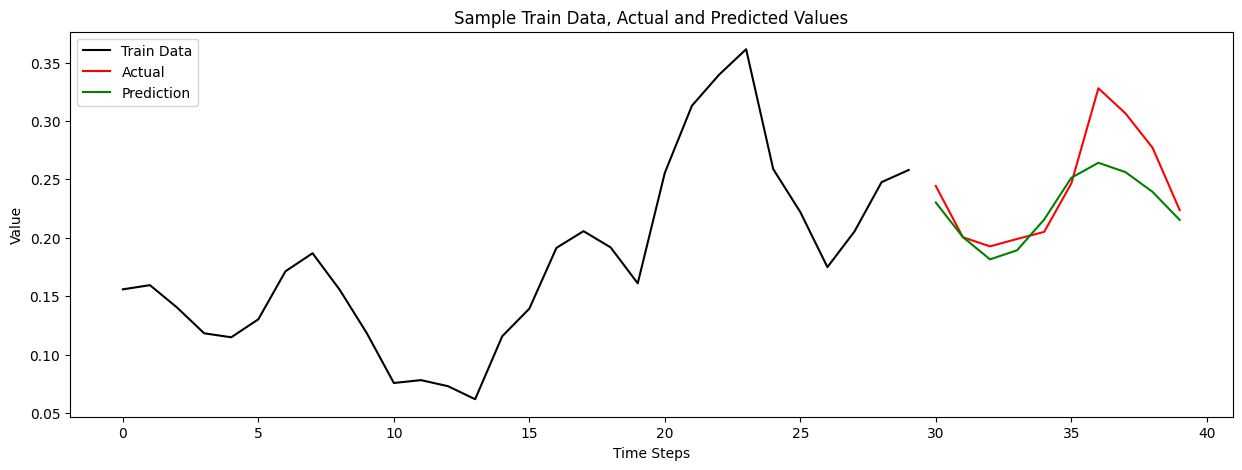

In [ ]:
# 시각화
plt.figure(figsize=(15, 5))

# 훈련 데이터 부분 (노란색)
plt.plot(np.arange(len(sample_seq)), sample_seq, label='Train Data', color='black')

# 실제 레이블 부분 (빨간색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
actual_indices = np.arange(len(sample_seq), len(sample_seq) + len(sample_label))
plt.plot(actual_indices, sample_label, label='Actual', color='red')

# 예측 부분 (초록색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
pred_indices = np.arange(len(sample_seq), len(sample_seq) + len(sample_pred[0]))
plt.plot(pred_indices, sample_pred[0], label='Prediction', color='green')

plt.title('Sample Train Data, Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

## 대분류 한개에 대한 데이터로더 정의

In [ ]:
window_size = 30
forcast_size= 10
batch_size = 32

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/train.csv',encoding='utf-8').groupby('대분류').sum()
df = df.drop(columns=['ID'], axis=0)
df = df.head(1)
df

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
대분류,,,,,,,,,,,,,,,,,,,,,
B002-C001-0001,84536,73870,57336,54769,66988,75390,85298,103458,109806,102022,...,2481,2580,2615,45184,37781,37409,37161,31807,41884,55732


In [ ]:
def time_slide_df(df, window_size, forcast_size):
    df_ = df.copy()
    data_list = []
    dap_list = []
    for idx in range(0, df_.shape[0]-window_size-forcast_size):
        x = df_[idx:idx+window_size].reshape(window_size, 1)
        y = df_[idx+window_size:idx+window_size+forcast_size]
        data_list.append(x)
        dap_list.append(y)
    return np.array(data_list, dtype='float32'), np.array(dap_list, dtype='float32')

scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df.T).T
df


array([[0.57231927, 0.49826423, 0.3834671 , 0.36564418, 0.45048185,
        0.50881773, 0.57760991, 0.7036965 , 0.74777127, 0.69372622,
        0.4402269 , 0.50826923, 0.5539409 , 0.57999833, 0.55730136,
        0.5188991 , 0.45385619, 0.54880995, 0.54951121, 0.63093982,
        0.65263699, 0.57356903, 0.54728247, 0.51433749, 0.59869609,
        0.66452356, 0.68797039, 0.53686089, 0.4017205 , 0.28097314,
        0.24845169, 0.22930958, 0.24988891, 0.30955092, 0.49559114,
        0.66112145, 0.65199128, 0.57787375, 0.5651054 , 0.59970284,
        0.64959591, 0.63383509, 0.58778849, 0.52185686, 0.45412003,
        0.46351404, 0.60064015, 0.6747924 , 0.707418  , 0.5961202 ,
        0.57106257, 0.50317994, 0.47122782, 0.5170453 , 0.5953634 ,
        0.64168773, 0.58338656, 0.55516288, 0.47703224, 0.46072291,
        0.49186964, 0.56564696, 0.66359319, 0.69445524, 0.62918321,
        0.57306218, 0.55254534, 0.61706057, 0.62387175, 0.61052712,
        0.71309051, 0.7805635 , 0.75935929, 0.55

In [ ]:
combined_X = []
combined_y = []

for group_data in df:
  sales_data = group_data.flatten()
  X, y = time_slide_df(sales_data, window_size, forcast_size) #length = 30
  combined_X.append(X)
  combined_y.append(y)


## 개별
## group_data = data
## sales_data = group_data.flatten()
## X, y = time_slide_df(sales_data, window_size, forcast_size) #length = 30
## combined_X.append(X)
## combined_y.append(y)

In [ ]:
combined_X = np.concatenate(combined_X, axis=0)
combined_y = np.concatenate(combined_y, axis=0)

# 스케일링된 데이터로 데이터셋 재구성
train_size = int(0.8 * len(combined_X))
X_train, X_test = combined_X[:train_size], combined_X[train_size:]
y_train, y_test = combined_y[:train_size], combined_y[train_size:]

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((335, 30, 1), (84, 30, 1), (335, 10), (84, 10))

In [ ]:
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [ ]:
# PyTorch 데이터셋 및 데이터 로더
train_dataset = Data(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
test_dataset = Data(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
epoch = 100
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)

    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, Model Save".format(valid_loss))
        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))

  6%|▌         | 6/100 [00:00<00:03, 25.51it/s]

valid_loss=0.049, Model Save
epoch = 1, train_loss : 0.019, valid_loss : 0.049
epoch = 2, train_loss : 0.012, valid_loss : 0.050
epoch = 3, train_loss : 0.011, valid_loss : 0.050
epoch = 4, train_loss : 0.010, valid_loss : 0.050
epoch = 5, train_loss : 0.009, valid_loss : 0.051
epoch = 6, train_loss : 0.009, valid_loss : 0.049
valid_loss=0.049, Model Save
epoch = 7, train_loss : 0.009, valid_loss : 0.049
valid_loss=0.049, Model Save
epoch = 8, train_loss : 0.009, valid_loss : 0.049


 14%|█▍        | 14/100 [00:00<00:02, 32.24it/s]

valid_loss=0.049, Model Save
epoch = 9, train_loss : 0.009, valid_loss : 0.049
valid_loss=0.048, Model Save
epoch = 10, train_loss : 0.009, valid_loss : 0.048
valid_loss=0.048, Model Save
epoch = 11, train_loss : 0.009, valid_loss : 0.048
valid_loss=0.047, Model Save
epoch = 12, train_loss : 0.009, valid_loss : 0.047
valid_loss=0.047, Model Save
epoch = 13, train_loss : 0.009, valid_loss : 0.047
valid_loss=0.046, Model Save
epoch = 14, train_loss : 0.009, valid_loss : 0.046
valid_loss=0.046, Model Save
epoch = 15, train_loss : 0.009, valid_loss : 0.046
valid_loss=0.046, Model Save
epoch = 16, train_loss : 0.009, valid_loss : 0.046


 23%|██▎       | 23/100 [00:00<00:02, 37.05it/s]

valid_loss=0.045, Model Save
epoch = 17, train_loss : 0.009, valid_loss : 0.045
valid_loss=0.045, Model Save
epoch = 18, train_loss : 0.009, valid_loss : 0.045
valid_loss=0.044, Model Save
epoch = 19, train_loss : 0.008, valid_loss : 0.044
valid_loss=0.044, Model Save
epoch = 20, train_loss : 0.008, valid_loss : 0.044
valid_loss=0.044, Model Save
epoch = 21, train_loss : 0.008, valid_loss : 0.044
valid_loss=0.043, Model Save
epoch = 22, train_loss : 0.008, valid_loss : 0.043
valid_loss=0.043, Model Save
epoch = 23, train_loss : 0.008, valid_loss : 0.043
valid_loss=0.042, Model Save
epoch = 24, train_loss : 0.008, valid_loss : 0.042
valid_loss=0.042, Model Save
epoch = 25, train_loss : 0.008, valid_loss : 0.042


 32%|███▏      | 32/100 [00:00<00:01, 39.15it/s]

valid_loss=0.042, Model Save
epoch = 26, train_loss : 0.008, valid_loss : 0.042
valid_loss=0.041, Model Save
epoch = 27, train_loss : 0.008, valid_loss : 0.041
valid_loss=0.041, Model Save
epoch = 28, train_loss : 0.008, valid_loss : 0.041
valid_loss=0.041, Model Save
epoch = 29, train_loss : 0.008, valid_loss : 0.041
valid_loss=0.040, Model Save
epoch = 30, train_loss : 0.008, valid_loss : 0.040
valid_loss=0.040, Model Save
epoch = 31, train_loss : 0.008, valid_loss : 0.040
valid_loss=0.040, Model Save
epoch = 32, train_loss : 0.008, valid_loss : 0.040
valid_loss=0.039, Model Save
epoch = 33, train_loss : 0.008, valid_loss : 0.039
valid_loss=0.039, Model Save
epoch = 34, train_loss : 0.008, valid_loss : 0.039


 40%|████      | 40/100 [00:01<00:01, 35.69it/s]

valid_loss=0.038, Model Save
epoch = 35, train_loss : 0.008, valid_loss : 0.038
valid_loss=0.038, Model Save
epoch = 36, train_loss : 0.008, valid_loss : 0.038
valid_loss=0.038, Model Save
epoch = 37, train_loss : 0.008, valid_loss : 0.038
valid_loss=0.038, Model Save
epoch = 38, train_loss : 0.008, valid_loss : 0.038
valid_loss=0.037, Model Save
epoch = 39, train_loss : 0.008, valid_loss : 0.037
valid_loss=0.037, Model Save
epoch = 40, train_loss : 0.008, valid_loss : 0.037
valid_loss=0.037, Model Save
epoch = 41, train_loss : 0.008, valid_loss : 0.037


 49%|████▉     | 49/100 [00:01<00:01, 37.46it/s]

valid_loss=0.036, Model Save
epoch = 42, train_loss : 0.008, valid_loss : 0.036
valid_loss=0.036, Model Save
epoch = 43, train_loss : 0.008, valid_loss : 0.036
valid_loss=0.036, Model Save
epoch = 44, train_loss : 0.008, valid_loss : 0.036
valid_loss=0.035, Model Save
epoch = 45, train_loss : 0.008, valid_loss : 0.035
valid_loss=0.035, Model Save
epoch = 46, train_loss : 0.008, valid_loss : 0.035
valid_loss=0.035, Model Save
epoch = 47, train_loss : 0.008, valid_loss : 0.035
valid_loss=0.035, Model Save
epoch = 48, train_loss : 0.008, valid_loss : 0.035
valid_loss=0.034, Model Save
epoch = 49, train_loss : 0.008, valid_loss : 0.034


 57%|█████▋    | 57/100 [00:01<00:01, 37.09it/s]

valid_loss=0.034, Model Save
epoch = 50, train_loss : 0.008, valid_loss : 0.034
valid_loss=0.034, Model Save
epoch = 51, train_loss : 0.008, valid_loss : 0.034
valid_loss=0.034, Model Save
epoch = 52, train_loss : 0.008, valid_loss : 0.034
valid_loss=0.033, Model Save
epoch = 53, train_loss : 0.008, valid_loss : 0.033
valid_loss=0.033, Model Save
epoch = 54, train_loss : 0.008, valid_loss : 0.033
valid_loss=0.033, Model Save
epoch = 55, train_loss : 0.008, valid_loss : 0.033
valid_loss=0.033, Model Save
epoch = 56, train_loss : 0.008, valid_loss : 0.033
valid_loss=0.032, Model Save
epoch = 57, train_loss : 0.008, valid_loss : 0.032


 61%|██████    | 61/100 [00:01<00:01, 36.38it/s]

valid_loss=0.032, Model Save
epoch = 58, train_loss : 0.008, valid_loss : 0.032
valid_loss=0.032, Model Save
epoch = 59, train_loss : 0.008, valid_loss : 0.032
valid_loss=0.032, Model Save
epoch = 60, train_loss : 0.008, valid_loss : 0.032
valid_loss=0.031, Model Save
epoch = 61, train_loss : 0.008, valid_loss : 0.031
valid_loss=0.031, Model Save
epoch = 62, train_loss : 0.008, valid_loss : 0.031
valid_loss=0.031, Model Save
epoch = 63, train_loss : 0.008, valid_loss : 0.031
valid_loss=0.031, Model Save
epoch = 64, train_loss : 0.008, valid_loss : 0.031
valid_loss=0.031, Model Save
epoch = 65, train_loss : 0.008, valid_loss : 0.031


 70%|███████   | 70/100 [00:01<00:00, 36.88it/s]

valid_loss=0.030, Model Save
epoch = 66, train_loss : 0.008, valid_loss : 0.030
valid_loss=0.030, Model Save
epoch = 67, train_loss : 0.008, valid_loss : 0.030
valid_loss=0.030, Model Save
epoch = 68, train_loss : 0.008, valid_loss : 0.030
valid_loss=0.030, Model Save
epoch = 69, train_loss : 0.008, valid_loss : 0.030
valid_loss=0.030, Model Save
epoch = 70, train_loss : 0.008, valid_loss : 0.030
valid_loss=0.029, Model Save
epoch = 71, train_loss : 0.008, valid_loss : 0.029
valid_loss=0.029, Model Save
epoch = 72, train_loss : 0.008, valid_loss : 0.029
valid_loss=0.029, Model Save
epoch = 73, train_loss : 0.008, valid_loss : 0.029


 78%|███████▊  | 78/100 [00:02<00:00, 36.38it/s]

valid_loss=0.029, Model Save
epoch = 74, train_loss : 0.008, valid_loss : 0.029
valid_loss=0.029, Model Save
epoch = 75, train_loss : 0.008, valid_loss : 0.029
valid_loss=0.029, Model Save
epoch = 76, train_loss : 0.008, valid_loss : 0.029
valid_loss=0.028, Model Save
epoch = 77, train_loss : 0.008, valid_loss : 0.028
valid_loss=0.028, Model Save
epoch = 78, train_loss : 0.008, valid_loss : 0.028
valid_loss=0.028, Model Save
epoch = 79, train_loss : 0.008, valid_loss : 0.028
valid_loss=0.028, Model Save
epoch = 80, train_loss : 0.008, valid_loss : 0.028
valid_loss=0.028, Model Save
epoch = 81, train_loss : 0.008, valid_loss : 0.028


 86%|████████▌ | 86/100 [00:02<00:00, 35.60it/s]

valid_loss=0.028, Model Save
epoch = 82, train_loss : 0.008, valid_loss : 0.028
valid_loss=0.027, Model Save
epoch = 83, train_loss : 0.008, valid_loss : 0.027
valid_loss=0.027, Model Save
epoch = 84, train_loss : 0.008, valid_loss : 0.027
valid_loss=0.027, Model Save
epoch = 85, train_loss : 0.008, valid_loss : 0.027
valid_loss=0.027, Model Save
epoch = 86, train_loss : 0.008, valid_loss : 0.027
valid_loss=0.027, Model Save
epoch = 87, train_loss : 0.008, valid_loss : 0.027
valid_loss=0.027, Model Save
epoch = 88, train_loss : 0.008, valid_loss : 0.027
valid_loss=0.027, Model Save
epoch = 89, train_loss : 0.008, valid_loss : 0.027


 94%|█████████▍| 94/100 [00:02<00:00, 36.55it/s]

valid_loss=0.026, Model Save
epoch = 90, train_loss : 0.008, valid_loss : 0.026
valid_loss=0.026, Model Save
epoch = 91, train_loss : 0.008, valid_loss : 0.026
valid_loss=0.026, Model Save
epoch = 92, train_loss : 0.008, valid_loss : 0.026
valid_loss=0.026, Model Save
epoch = 93, train_loss : 0.008, valid_loss : 0.026
valid_loss=0.026, Model Save
epoch = 94, train_loss : 0.008, valid_loss : 0.026
valid_loss=0.026, Model Save
epoch = 95, train_loss : 0.008, valid_loss : 0.026
valid_loss=0.026, Model Save
epoch = 96, train_loss : 0.008, valid_loss : 0.026
valid_loss=0.026, Model Save
epoch = 97, train_loss : 0.008, valid_loss : 0.026


100%|██████████| 100/100 [00:02<00:00, 35.53it/s]

valid_loss=0.025, Model Save
epoch = 98, train_loss : 0.008, valid_loss : 0.025
valid_loss=0.025, Model Save
epoch = 99, train_loss : 0.008, valid_loss : 0.025
valid_loss=0.025, Model Save
epoch = 100, train_loss : 0.008, valid_loss : 0.025


In [ ]:
import matplotlib.pyplot as plt
# 임의의 훈련 샘플 선택
sample_seq, sample_label = test_dataset[0]

torch_tensor = torch.from_numpy(sample_seq)

# unsqueeze 메서드를 사용하여 차원 추가
torch_tensor = torch_tensor.unsqueeze(0)

DLinear_model.eval()
with torch.no_grad():
    sample_pred= DLinear_model(torch_tensor)  # 배치 차원 추가

# 실제 값과 예측 값을 numpy 배열로 변환
sample_seq = sample_seq
sample_label = sample_label
sample_pred = sample_pred.numpy()

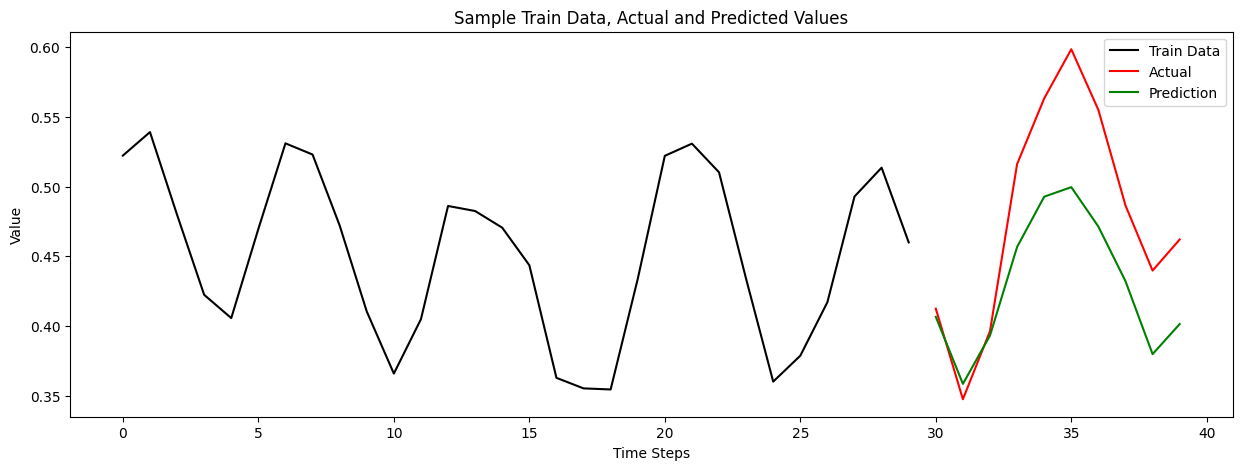

In [ ]:
# 시각화
plt.figure(figsize=(15, 5))

# 훈련 데이터 부분 (노란색)
plt.plot(np.arange(len(sample_seq)), sample_seq, label='Train Data', color='black')

# 실제 레이블 부분 (빨간색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
actual_indices = np.arange(len(sample_seq), len(sample_seq) + len(sample_label))
plt.plot(actual_indices, sample_label, label='Actual', color='red')

# 예측 부분 (초록색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
pred_indices = np.arange(len(sample_seq), len(sample_seq) + len(sample_pred[0]))
plt.plot(pred_indices, sample_pred[0], label='Prediction', color='green')

plt.title('Sample Train Data, Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

# 완료

### dlinear model

In [ ]:
class moving_avg(torch.nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
    	  # [BATCH SIZE, SEQ_LEN, CHANNEL]
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x # [BATCH SIZE, SEQ_LEN, CHANNEL]

class series_decomp(torch.nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size

        # Decompsition Kernel Size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size


        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        trend_init, seasonal_init = self.decompsition(x)
        # seasonal_init: [Batch, Input length, Channel]
        # trend_init: [Batch, Input length, Channel]
        trend_init, seasonal_init = trend_init, seasonal_init
        # seasonal_init: [Batch, Channel, Input length]
        # trend_init: [Batch, Channel, Input length]

        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

### data engineering

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/train.csv', encoding='utf-8')
sale_df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/sales.csv', encoding='utf-8')
brand_cnt_df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/brand_keyword_cnt.csv', encoding='utf-8')

brand_cnt_data = brand_cnt_df.copy()
sale_data = sale_df.copy()
data = df.copy()

data.shape, sale_data.shape, brand_cnt_data.shape

((15890, 465), (15890, 465), (3170, 460))

In [ ]:
# 평균 판매량
mean_data = data.groupby('대분류').mean().drop('ID', axis=1)
mean_data = pd.DataFrame(mean_data.iloc[1,:]).T
mean_data

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
B002-C001-0002,10.372375,7.707961,7.142231,7.569564,9.549662,10.701844,10.391912,8.728957,8.790305,7.79067,...,0.403871,0.381961,0.363794,8.962662,9.273507,6.682947,6.286927,6.691619,8.475991,8.843801


In [ ]:
# 평균 판매금액
sale_data = sale_data.groupby('대분류').mean().drop('ID', axis=1)
sale_data = pd.DataFrame(sale_data.iloc[1,:]).T
sale_data

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
B002-C001-0002,48616.890634,35176.793865,31246.600329,33629.603798,42851.009677,46701.290853,44709.472339,40345.858134,39452.612744,35805.023736,...,2763.475443,2512.2631,2578.184225,40620.481103,40364.61384,34943.432536,30839.816505,32950.821618,42866.663319,41179.389264


In [ ]:
# 평균 언급량
brand_data = pd.merge(data[['대분류','브랜드']], brand_cnt_data, on = '브랜드', how = 'inner').groupby('대분류').mean()
brand_data = pd.DataFrame(brand_data.iloc[1,:]).T
brand_data

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
B002-C001-0002,4.781401,4.943316,6.065372,5.837226,5.922064,5.855639,5.631896,4.944564,5.229944,6.631059,...,4.878153,5.360162,5.386088,4.988276,4.858749,4.579266,3.951934,4.130802,5.10726,5.1004


In [ ]:
df = pd.concat([mean_data, sale_data,brand_data], axis=0)
df

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
B002-C001-0002,10.372375,7.707961,7.142231,7.569564,9.549662,10.701844,10.391912,8.728957,8.790305,7.790670,...,0.403871,0.381961,0.363794,8.962662,9.273507,6.682947,6.286927,6.691619,8.475991,8.843801
B002-C001-0002,48616.890634,35176.793865,31246.600329,33629.603798,42851.009677,46701.290853,44709.472339,40345.858134,39452.612744,35805.023736,...,2763.475443,2512.263100,2578.184225,40620.481103,40364.613840,34943.432536,30839.816505,32950.821618,42866.663319,41179.389264
B002-C001-0002,4.781401,4.943316,6.065372,5.837226,5.922064,5.855639,5.631896,4.944564,5.229944,6.631059,...,4.878153,5.360162,5.386088,4.988276,4.858749,4.579266,3.951934,4.130802,5.107260,5.100400


In [ ]:
# df.to_csv('/content/drive/MyDrive/time_series confer/data/data.csv', index=False) # 파일 저장

### data load

In [ ]:
window_size = 30
forcast_size= 10
batch_size = 32

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/data.csv', encoding='utf-8')
print(df.shape)
df

(3, 459)


,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,10.372375,7.707961,7.142231,7.569564,9.549662,10.701844,10.391912,8.728957,8.790305,7.790670,...,0.403871,0.381961,0.363794,8.962662,9.273507,6.682947,6.286927,6.691619,8.475991,8.843801
1,48616.890634,35176.793865,31246.600329,33629.603798,42851.009677,46701.290853,44709.472339,40345.858134,39452.612744,35805.023736,...,2763.475443,2512.263100,2578.184225,40620.481103,40364.613840,34943.432536,30839.816505,32950.821618,42866.663319,41179.389264
2,4.781401,4.943316,6.065372,5.837226,5.922064,5.855639,5.631896,4.944564,5.229944,6.631059,...,4.878153,5.360162,5.386088,4.988276,4.858749,4.579266,3.951934,4.130802,5.107260,5.100400


In [ ]:
def create_sequences(data, seq_length):
  xs = []
  ys = []
  for i in range(len(data.T)-seq_length-10):
    x = data[:, i:(i+seq_length)]
    y = data[:, (i+seq_length):(i+seq_length+10)]
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

def column_data_preprocessing(data, column):
  if column == '판매량':
    df = pd.DataFrame(data.iloc[0,:])
  elif column == '판매금액':
    df = pd.DataFrame(data.iloc[1,:])
  elif column == '언급량':
    df = pd.DataFrame(data.iloc[2,:])

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(df).T

  X, y =create_sequences(scaled_data, seq_length=30)

  # 스케일링된 데이터로 데이터셋 재구성
  train_size = int(0.64 * len(X))
  val_size = int(0.16 * len(X))
  test_size = int(0.20 * len(X))

  X_train, X_val, X_test = X[:train_size], X[train_size:(train_size+val_size)], X[(train_size+val_size):]
  y_train, y_val, y_test = y[:train_size], y[train_size:(train_size+val_size)], y[(train_size+val_size):]



  return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = column_data_preprocessing(df, '판매량')

In [ ]:
class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.float32)

In [ ]:
# PyTorch 데이터셋 및 데이터 로더
train_dataset = Data(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
val_dataset = Data(X_val,y_val)
val_loader = DataLoader(val_dataset, batch_size=32)
test_dataset = Data(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

### train

In [ ]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []

epoch = 50
lr = 0.001
DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    DLinear_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.permute(0,2,1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.permute(0,2,1))
            valid_loss_list.append(valid_loss)

        for data, target in test_loader:
            output = DLinear_model(data)
            test_loss = criterion(output, target.permute(0,2,1))
            test_loss_list.append(test_loss)



    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))

        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())


    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  8%|▊         | 4/50 [00:00<00:01, 32.26it/s]

valid_loss=0.011, test_los0.040, Model Save
epoch = 1, train_loss : 0.031, valid_loss : 0.011, test_loss : 0.040
valid_loss=0.005, test_los0.032, Model Save
epoch = 2, train_loss : 0.018, valid_loss : 0.005, test_loss : 0.032
valid_loss=0.003, test_los0.028, Model Save
epoch = 3, train_loss : 0.014, valid_loss : 0.003, test_loss : 0.028
valid_loss=0.002, test_los0.027, Model Save
epoch = 4, train_loss : 0.014, valid_loss : 0.002, test_loss : 0.027
valid_loss=0.002, test_los0.028, Model Save
epoch = 5, train_loss : 0.013, valid_loss : 0.002, test_loss : 0.028
valid_loss=0.002, test_los0.028, Model Save
epoch = 6, train_loss : 0.013, valid_loss : 0.002, test_loss : 0.028
epoch = 7, train_loss : 0.013, valid_loss : 0.002, test_loss : 0.028


 24%|██▍       | 12/50 [00:00<00:01, 33.33it/s]

epoch = 8, train_loss : 0.013, valid_loss : 0.002, test_loss : 0.028
epoch = 9, train_loss : 0.013, valid_loss : 0.002, test_loss : 0.029
epoch = 10, train_loss : 0.013, valid_loss : 0.002, test_loss : 0.029
epoch = 11, train_loss : 0.013, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 12, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 13, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 14, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029


 40%|████      | 20/50 [00:00<00:00, 32.05it/s]

valid_loss=0.002, test_los0.029, Model Save
epoch = 15, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 16, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 17, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 18, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 19, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 20, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 21, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029


 56%|█████▌    | 28/50 [00:00<00:00, 31.95it/s]

valid_loss=0.002, test_los0.029, Model Save
epoch = 22, train_loss : 0.012, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 23, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 24, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 25, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 26, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 27, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.029, Model Save
epoch = 28, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.029


 64%|██████▍   | 32/50 [00:01<00:00, 31.04it/s]

valid_loss=0.002, test_los0.029, Model Save
epoch = 29, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.029
valid_loss=0.002, test_los0.030, Model Save
epoch = 30, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 31, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 32, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 33, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 34, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 35, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030


 80%|████████  | 40/50 [00:01<00:00, 31.73it/s]

valid_loss=0.002, test_los0.030, Model Save
epoch = 36, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 37, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 38, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 39, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 40, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 41, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030
valid_loss=0.002, test_los0.030, Model Save
epoch = 42, train_loss : 0.011, valid_loss : 0.002, test_loss : 0.030


 96%|█████████▌| 48/50 [00:01<00:00, 31.97it/s]

valid_loss=0.002, test_los0.031, Model Save
epoch = 43, train_loss : 0.010, valid_loss : 0.002, test_loss : 0.031
valid_loss=0.002, test_los0.031, Model Save
epoch = 44, train_loss : 0.010, valid_loss : 0.002, test_loss : 0.031
valid_loss=0.002, test_los0.031, Model Save
epoch = 45, train_loss : 0.010, valid_loss : 0.002, test_loss : 0.031
valid_loss=0.002, test_los0.031, Model Save
epoch = 46, train_loss : 0.010, valid_loss : 0.002, test_loss : 0.031
epoch = 47, train_loss : 0.010, valid_loss : 0.002, test_loss : 0.031
epoch = 48, train_loss : 0.010, valid_loss : 0.002, test_loss : 0.031
epoch = 49, train_loss : 0.010, valid_loss : 0.002, test_loss : 0.031


100%|██████████| 50/50 [00:01<00:00, 31.66it/s]

epoch = 50, train_loss : 0.010, valid_loss : 0.002, test_loss : 0.031


### test

In [ ]:
import matplotlib.pyplot as plt
# 임의의 훈련 샘플 선택
sample_seq, sample_label = test_dataset[10]

DLinear_model.eval()
with torch.no_grad():
    sample_pred= DLinear_model(sample_seq.unsqueeze(-1).permute(2,0,1))
    sample_pred = torch.squeeze(sample_pred, dim=0).permute(1,0)

# 실제 값과 예측 값을 numpy 배열로 변환
sample_seq = sample_seq
sample_label = sample_label.numpy()
sample_pred = sample_pred.numpy()

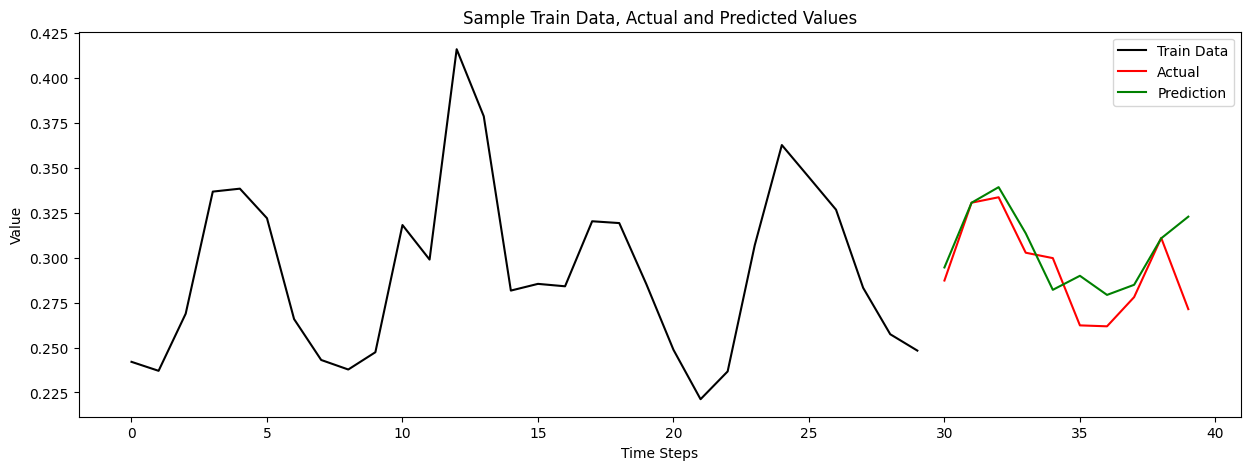

In [ ]:
# 시각화
plt.figure(figsize=(15, 5))

# 훈련 데이터 부분 (노란색)
plt.plot(np.arange(len(sample_seq[0])), sample_seq[0], label='Train Data', color='black')

# 실제 레이블 부분 (빨간색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
actual_indices = np.arange(len(sample_seq[0]), len(sample_seq[0]) + len(sample_label[0]))
plt.plot(actual_indices, sample_label[0], label='Actual', color='red')

# 예측 부분 (초록색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
pred_indices = np.arange(len(sample_seq[0]), len(sample_seq[0]) + len(sample_pred[0]))
plt.plot(pred_indices, sample_pred[0], label='Prediction', color='green')

plt.title('Sample Train Data, Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

# final

### 패키지 설치

In [1]:
## colab 환경
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from joblib import Parallel, delayed

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')

## data load & engineering

### engineering

In [3]:
## 판매량 데이터
df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/train.csv', encoding='utf-8')

## 판매금액 데이터
sale_df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/sales.csv', encoding='utf-8')

## 언급량 데이터
brand_cnt_df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/brand_keyword_cnt.csv', encoding='utf-8')

brand_cnt_data = brand_cnt_df.copy()
sale_data = sale_df.copy()
data = df.copy()

data.shape, sale_data.shape, brand_cnt_data.shape

((15890, 465), (15890, 465), (3170, 460))

In [4]:
# 평균 판매량
mean_data = data.groupby('대분류').mean().drop('ID', axis=1)
mean_data = pd.DataFrame(mean_data.iloc[1,:]).T

# 평균 판매금액
sale_data = sale_data.groupby('대분류').mean().drop('ID', axis=1)
sale_data = pd.DataFrame(sale_data.iloc[1,:]).T

# 평균 언급량
brand_data = pd.merge(data[['대분류','브랜드']], brand_cnt_data, on = '브랜드', how = 'inner').groupby('대분류').mean()
brand_data = pd.DataFrame(brand_data.iloc[1,:]).T

In [5]:
df = pd.concat([mean_data, sale_data,brand_data], axis=0)
df

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
B002-C001-0002,10.372375,7.707961,7.142231,7.569564,9.549662,10.701844,10.391912,8.728957,8.790305,7.790670,...,0.403871,0.381961,0.363794,8.962662,9.273507,6.682947,6.286927,6.691619,8.475991,8.843801
B002-C001-0002,48616.890634,35176.793865,31246.600329,33629.603798,42851.009677,46701.290853,44709.472339,40345.858134,39452.612744,35805.023736,...,2763.475443,2512.263100,2578.184225,40620.481103,40364.613840,34943.432536,30839.816505,32950.821618,42866.663319,41179.389264
B002-C001-0002,4.781401,4.943316,6.065372,5.837226,5.922064,5.855639,5.631896,4.944564,5.229944,6.631059,...,4.878153,5.360162,5.386088,4.988276,4.858749,4.579266,3.951934,4.130802,5.107260,5.100400


In [6]:
# 파일 저장
# df.to_csv('/content/drive/MyDrive/time_series confer/data/data.csv', index=False)

In [7]:
window_size = 30
forcast_size= 10
batch_size = 32

In [8]:
df = pd.read_csv('/content/drive/MyDrive/time_series confer/data/data.csv', encoding='utf-8')
print(df.shape)
df

(3, 459)


,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,10.372375,7.707961,7.142231,7.569564,9.549662,10.701844,10.391912,8.728957,8.790305,7.790670,...,0.403871,0.381961,0.363794,8.962662,9.273507,6.682947,6.286927,6.691619,8.475991,8.843801
1,48616.890634,35176.793865,31246.600329,33629.603798,42851.009677,46701.290853,44709.472339,40345.858134,39452.612744,35805.023736,...,2763.475443,2512.263100,2578.184225,40620.481103,40364.613840,34943.432536,30839.816505,32950.821618,42866.663319,41179.389264
2,4.781401,4.943316,6.065372,5.837226,5.922064,5.855639,5.631896,4.944564,5.229944,6.631059,...,4.878153,5.360162,5.386088,4.988276,4.858749,4.579266,3.951934,4.130802,5.107260,5.100400


### load

In [9]:
window_size = 30 # time-series data size(30개 데이터 훈련)
forcast_size = 10 # predicted data size(10개 데이터 예측)
batch_size = 32

# window size에 맞는 dataset 구성

def create_sequences(data, seq_length, forcast_size):
  xs = []
  ys = []
  for i in range(len(data.T)-seq_length-forcast_size):
    x = data[:, i:(i+seq_length)]
    y = data[:, (i+seq_length):(i+seq_length+forcast_size)]
    xs.append(x)
    ys.append(y)
  return np.array(xs), np.array(ys)

# 각각의 feature에 따른 train, val, test split 함수

def column_data_preprocessing(data, column):
  if column == '판매량':
    df = pd.DataFrame(data.iloc[0,:])
  elif column == '판매금액':
    df = pd.DataFrame(data.iloc[1,:])
  elif column == '언급량':
    df = pd.DataFrame(data.iloc[2,:])

  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(df).T

  X, y =create_sequences(scaled_data, seq_length=30, forcast_size=10)

  # 스케일링된 데이터로 데이터셋 재구성
  train_size = int(0.64 * len(X))
  val_size = int(0.16 * len(X))
  test_size = int(0.20 * len(X))

  X_train, X_val, X_test = X[:train_size], X[train_size:(train_size+val_size)], X[(train_size+val_size):]
  y_train, y_val, y_test = y[:train_size], y[train_size:(train_size+val_size)], y[(train_size+val_size):]


  return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
## customdataset 구성

class Data(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.Y[idx], dtype=torch.float32)

## dlinear model

In [11]:
class moving_avg(torch.nn.Module):
    """
    Moving average block to highlight the trend of time series
    """

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
    	  # [BATCH SIZE, SEQ_LEN, CHANNEL]
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x # [BATCH SIZE, SEQ_LEN, CHANNEL]

class series_decomp(torch.nn.Module):
    """
    Series decomposition block
    """

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

class LTSF_DLinear(torch.nn.Module):
    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size

        # Decompsition Kernel Size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size


        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        trend_init, seasonal_init = self.decompsition(x)
        # seasonal_init: [Batch, Input length, Channel]
        # trend_init: [Batch, Input length, Channel]
        trend_init, seasonal_init = trend_init, seasonal_init
        # seasonal_init: [Batch, Channel, Input length]
        # trend_init: [Batch, Channel, Input length]

        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

## 판매량

In [42]:
X_train, X_val, X_test, y_train, y_val, y_test = column_data_preprocessing(df, '판매량')

# PyTorch 데이터셋 및 데이터 로더
train_dataset = Data(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
val_dataset = Data(X_val,y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = Data(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

### train

In [43]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []

epoch = 280 # epoch 수
lr = 0.001 # learning rate

DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )

criterion = torch.nn.MSELoss() # mse loss 계산
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr) # Adam optimizer 사용
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []

    DLinear_model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.permute(0,2,1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())


    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()

    with torch.no_grad():
        val_losses = []
        test_losses = []

        for data, target in val_loader:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.permute(0,2,1))
            val_losses.append(valid_loss.item())

        valid_loss_list.append(np.mean(val_losses))

        for data, target in test_loader:
            output = DLinear_model(data)
            test_loss = criterion(output, target.permute(0,2,1))
            test_losses.append(test_loss.item())

        test_loss_list.append(np.mean(test_losses))



    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss

        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    if (epoch % 10 == 0):
      print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))

  5%|▍         | 13/280 [00:00<00:06, 40.20it/s]

epoch = 10, train_loss : 0.012, valid_loss : 0.002


 10%|▉         | 27/280 [00:00<00:06, 39.02it/s]

epoch = 20, train_loss : 0.011, valid_loss : 0.002


 12%|█▎        | 35/280 [00:00<00:06, 37.09it/s]

epoch = 30, train_loss : 0.011, valid_loss : 0.002


 17%|█▋        | 47/280 [00:01<00:06, 36.10it/s]

epoch = 40, train_loss : 0.010, valid_loss : 0.002


 20%|██        | 56/280 [00:01<00:06, 36.76it/s]

epoch = 50, train_loss : 0.010, valid_loss : 0.002


 23%|██▎       | 65/280 [00:01<00:05, 38.07it/s]

epoch = 60, train_loss : 0.010, valid_loss : 0.002


 28%|██▊       | 78/280 [00:02<00:05, 39.08it/s]

epoch = 70, train_loss : 0.010, valid_loss : 0.002


 31%|███       | 86/280 [00:02<00:05, 36.91it/s]

epoch = 80, train_loss : 0.010, valid_loss : 0.002


 34%|███▍      | 95/280 [00:02<00:05, 36.18it/s]

epoch = 90, train_loss : 0.009, valid_loss : 0.002


 37%|███▋      | 104/280 [00:02<00:04, 37.74it/s]

epoch = 100, train_loss : 0.009, valid_loss : 0.002


 42%|████▏     | 117/280 [00:03<00:04, 37.10it/s]

epoch = 110, train_loss : 0.009, valid_loss : 0.002


 45%|████▌     | 126/280 [00:03<00:04, 38.00it/s]

epoch = 120, train_loss : 0.009, valid_loss : 0.002


 48%|████▊     | 135/280 [00:03<00:03, 39.51it/s]

epoch = 130, train_loss : 0.009, valid_loss : 0.002


 53%|█████▎    | 148/280 [00:03<00:03, 39.57it/s]

epoch = 140, train_loss : 0.009, valid_loss : 0.002


 56%|█████▌    | 157/280 [00:04<00:03, 39.88it/s]

epoch = 150, train_loss : 0.009, valid_loss : 0.002


 59%|█████▉    | 165/280 [00:04<00:03, 38.04it/s]

epoch = 160, train_loss : 0.009, valid_loss : 0.002


 63%|██████▎   | 177/280 [00:04<00:02, 37.96it/s]

epoch = 170, train_loss : 0.009, valid_loss : 0.002


 66%|██████▋   | 186/280 [00:04<00:02, 38.85it/s]

epoch = 180, train_loss : 0.009, valid_loss : 0.002


 69%|██████▉   | 194/280 [00:05<00:02, 37.78it/s]

epoch = 190, train_loss : 0.009, valid_loss : 0.002


 74%|███████▎  | 206/280 [00:05<00:01, 37.52it/s]

epoch = 200, train_loss : 0.009, valid_loss : 0.002


 76%|███████▋  | 214/280 [00:05<00:01, 37.85it/s]

epoch = 210, train_loss : 0.009, valid_loss : 0.002


 81%|████████▏ | 228/280 [00:05<00:01, 39.47it/s]

epoch = 220, train_loss : 0.009, valid_loss : 0.002


 85%|████████▍ | 237/280 [00:06<00:01, 40.06it/s]

epoch = 230, train_loss : 0.009, valid_loss : 0.002


 88%|████████▊ | 245/280 [00:06<00:00, 37.33it/s]

epoch = 240, train_loss : 0.009, valid_loss : 0.002


 90%|█████████ | 253/280 [00:06<00:00, 38.31it/s]

epoch = 250, train_loss : 0.009, valid_loss : 0.002


 93%|█████████▎| 261/280 [00:07<00:00, 26.02it/s]

epoch = 260, train_loss : 0.009, valid_loss : 0.002


 98%|█████████▊| 273/280 [00:07<00:00, 16.90it/s]

epoch = 270, train_loss : 0.009, valid_loss : 0.002


100%|██████████| 280/280 [00:08<00:00, 33.24it/s]

epoch = 280, train_loss : 0.009, valid_loss : 0.002


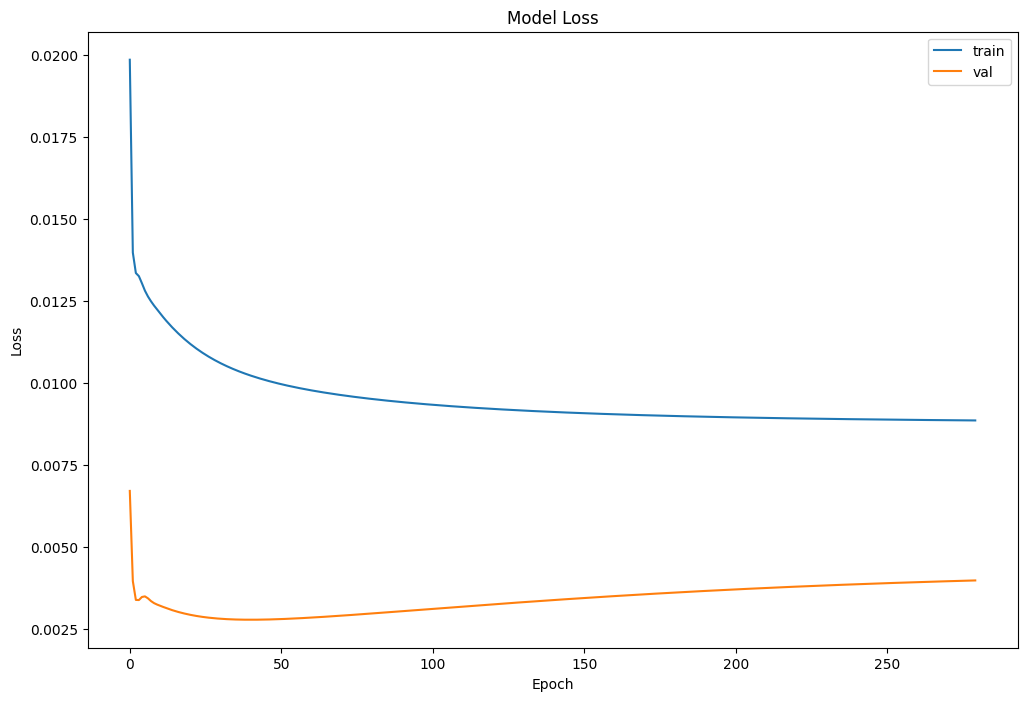

In [44]:
plt.figure(figsize=(12,8))

# 훈련 손실 그래프
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### test

In [49]:
import matplotlib.pyplot as plt
# 임의의 훈련 샘플 선택
sample_seq, sample_label = test_dataset[78]

DLinear_model.eval()
with torch.no_grad():
    sample_pred= DLinear_model(sample_seq.unsqueeze(-1).permute(2,0,1))
    sample_pred = torch.squeeze(sample_pred, dim=0).permute(1,0)

# 실제 값과 예측 값을 numpy 배열로 변환
sample_seq = sample_seq
sample_label = sample_label.numpy()
sample_pred = sample_pred.numpy()

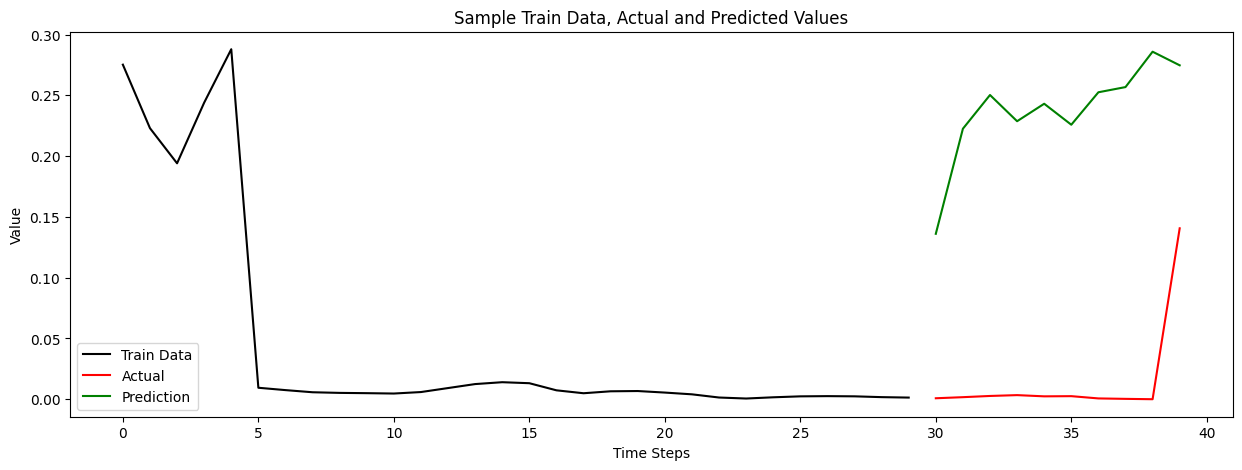

In [50]:
# 시각화
plt.figure(figsize=(15, 5))

# 훈련 데이터 부분 (노란색)
plt.plot(np.arange(len(sample_seq[0])), sample_seq[0], label='Train Data', color='black')

# 실제 레이블 부분 (빨간색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
actual_indices = np.arange(len(sample_seq[0]), len(sample_seq[0]) + len(sample_label[0]))
plt.plot(actual_indices, sample_label[0], label='Actual', color='red')

# 예측 부분 (초록색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
pred_indices = np.arange(len(sample_seq[0]), len(sample_seq[0]) + len(sample_pred[0]))
plt.plot(pred_indices, sample_pred[0], label='Prediction', color='green')

plt.title('Sample Train Data, Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

In [ ]:
DLinear_model.eval()
with torch.no_grad():
  for seq, labels in test_loader:
     y_pred  = DLinear_model(seq)
     val_loss = criterion(y_pred, labels)

  print(val_loss)

tensor(0.0306)


## 판매금액

In [51]:
X_train, X_val, X_test, y_train, y_val, y_test = column_data_preprocessing(df, '판매금액')

# PyTorch 데이터셋 및 데이터 로더
train_dataset = Data(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
val_dataset = Data(X_val,y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = Data(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

### train

In [52]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []

epoch = 280 # epoch 수
lr = 0.001 # learning rate

DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )

criterion = torch.nn.MSELoss() # mse loss 계산
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr) # Adam optimizer 사용
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []

    DLinear_model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.permute(0,2,1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())


    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()

    with torch.no_grad():
        val_losses = []
        test_losses = []

        for data, target in val_loader:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.permute(0,2,1))
            val_losses.append(valid_loss.item())

        valid_loss_list.append(np.mean(val_losses))

        for data, target in test_loader:
            output = DLinear_model(data)
            test_loss = criterion(output, target.permute(0,2,1))
            test_losses.append(test_loss.item())

        test_loss_list.append(np.mean(test_losses))



    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss

        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    if (epoch % 10 == 0):
      print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))

  5%|▍         | 13/280 [00:00<00:07, 35.03it/s]

epoch = 10, train_loss : 0.015, valid_loss : 0.011


  9%|▉         | 26/280 [00:00<00:07, 35.28it/s]

epoch = 20, train_loss : 0.013, valid_loss : 0.009


 12%|█▏        | 34/280 [00:00<00:07, 34.92it/s]

epoch = 30, train_loss : 0.011, valid_loss : 0.007


 17%|█▋        | 47/280 [00:01<00:06, 38.09it/s]

epoch = 40, train_loss : 0.010, valid_loss : 0.007


 20%|█▉        | 55/280 [00:01<00:05, 37.57it/s]

epoch = 50, train_loss : 0.010, valid_loss : 0.006


 24%|██▍       | 67/280 [00:01<00:05, 36.01it/s]

epoch = 60, train_loss : 0.009, valid_loss : 0.005


 27%|██▋       | 75/280 [00:02<00:05, 36.99it/s]

epoch = 70, train_loss : 0.009, valid_loss : 0.005


 30%|██▉       | 83/280 [00:02<00:06, 31.40it/s]

epoch = 80, train_loss : 0.009, valid_loss : 0.005


 34%|███▎      | 94/280 [00:02<00:06, 27.95it/s]

epoch = 90, train_loss : 0.008, valid_loss : 0.005


 37%|███▋      | 103/280 [00:03<00:06, 26.07it/s]

epoch = 100, train_loss : 0.008, valid_loss : 0.005


 41%|████      | 115/280 [00:03<00:06, 27.37it/s]

epoch = 110, train_loss : 0.008, valid_loss : 0.004


 44%|████▍     | 124/280 [00:03<00:05, 27.39it/s]

epoch = 120, train_loss : 0.008, valid_loss : 0.004


 48%|████▊     | 133/280 [00:04<00:05, 26.51it/s]

epoch = 130, train_loss : 0.008, valid_loss : 0.004


 50%|████▉     | 139/280 [00:04<00:07, 17.82it/s]

epoch = 140, train_loss : 0.008, valid_loss : 0.004


 55%|█████▍    | 153/280 [00:05<00:09, 13.78it/s]

epoch = 150, train_loss : 0.007, valid_loss : 0.004


 57%|█████▊    | 161/280 [00:06<00:10, 11.40it/s]

epoch = 160, train_loss : 0.007, valid_loss : 0.004


 61%|██████    | 171/280 [00:07<00:10, 10.06it/s]

epoch = 170, train_loss : 0.007, valid_loss : 0.004


 66%|██████▌   | 184/280 [00:09<00:06, 13.76it/s]

epoch = 180, train_loss : 0.007, valid_loss : 0.004


 68%|██████▊   | 191/280 [00:09<00:05, 16.51it/s]

epoch = 190, train_loss : 0.007, valid_loss : 0.004


 73%|███████▎  | 204/280 [00:10<00:03, 19.64it/s]

epoch = 200, train_loss : 0.007, valid_loss : 0.004


 76%|███████▋  | 214/280 [00:10<00:03, 21.95it/s]

epoch = 210, train_loss : 0.007, valid_loss : 0.004


 80%|███████▉  | 223/280 [00:11<00:02, 23.15it/s]

epoch = 220, train_loss : 0.007, valid_loss : 0.003


 83%|████████▎ | 232/280 [00:11<00:02, 23.29it/s]

epoch = 230, train_loss : 0.007, valid_loss : 0.003


 86%|████████▌ | 241/280 [00:11<00:01, 24.16it/s]

epoch = 240, train_loss : 0.007, valid_loss : 0.003


 90%|█████████ | 253/280 [00:12<00:01, 20.14it/s]

epoch = 250, train_loss : 0.007, valid_loss : 0.003


 94%|█████████▎| 262/280 [00:12<00:00, 22.49it/s]

epoch = 260, train_loss : 0.007, valid_loss : 0.003


 98%|█████████▊| 274/280 [00:13<00:00, 24.22it/s]

epoch = 270, train_loss : 0.007, valid_loss : 0.003


100%|██████████| 280/280 [00:13<00:00, 20.78it/s]

epoch = 280, train_loss : 0.007, valid_loss : 0.003


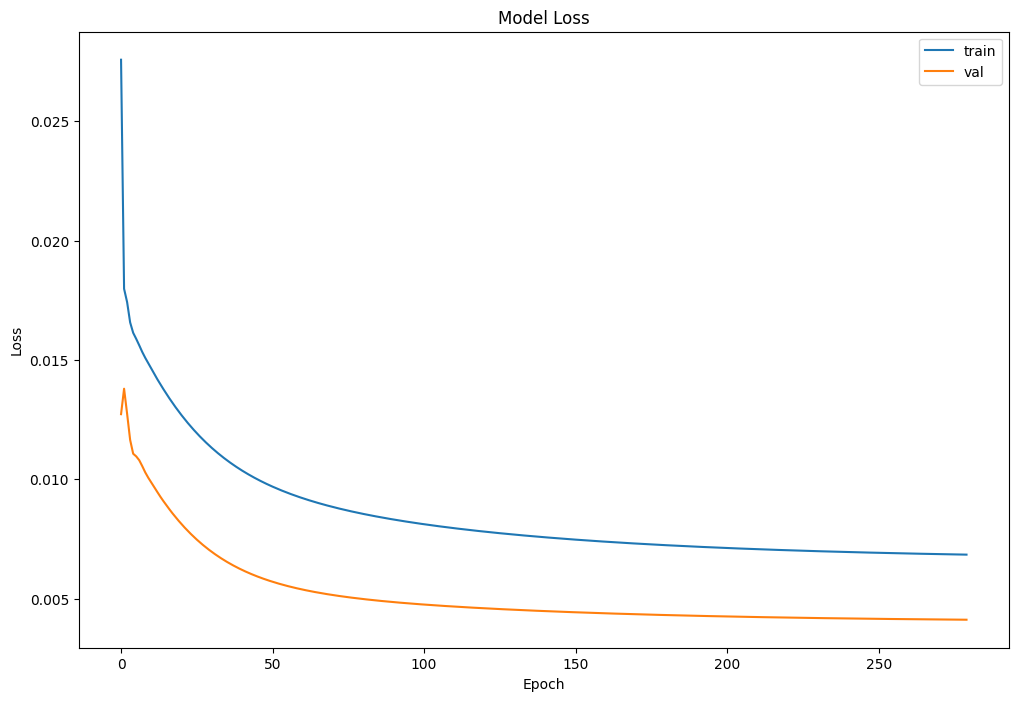

In [53]:
plt.figure(figsize=(12,8))

# 훈련 손실 그래프
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### test

In [56]:
import matplotlib.pyplot as plt
# 임의의 훈련 샘플 선택
sample_seq, sample_label = test_dataset[78]

DLinear_model.eval()
with torch.no_grad():
    sample_pred= DLinear_model(sample_seq.unsqueeze(-1).permute(2,0,1))
    sample_pred = torch.squeeze(sample_pred, dim=0).permute(1,0)

# 실제 값과 예측 값을 numpy 배열로 변환
sample_seq = sample_seq
sample_label = sample_label.numpy()
sample_pred = sample_pred.numpy()

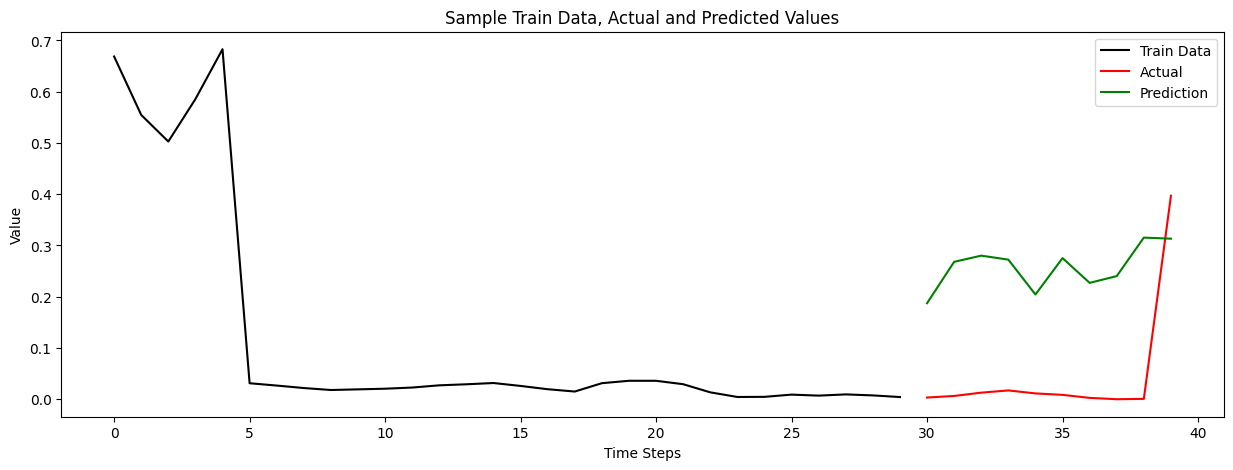

In [57]:
# 시각화
plt.figure(figsize=(15, 5))

# 훈련 데이터 부분 (노란색)
plt.plot(np.arange(len(sample_seq[0])), sample_seq[0], label='Train Data', color='black')

# 실제 레이블 부분 (빨간색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
actual_indices = np.arange(len(sample_seq[0]), len(sample_seq[0]) + len(sample_label[0]))
plt.plot(actual_indices, sample_label[0], label='Actual', color='red')

# 예측 부분 (초록색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
pred_indices = np.arange(len(sample_seq[0]), len(sample_seq[0]) + len(sample_pred[0]))
plt.plot(pred_indices, sample_pred[0], label='Prediction', color='green')

plt.title('Sample Train Data, Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

In [35]:
DLinear_model.eval()
with torch.no_grad():
  for seq, labels in test_loader:
     y_pred  = DLinear_model(seq)
     val_loss = criterion(y_pred, labels)

  print(val_loss)

tensor(0.0944)


## 언급량

In [58]:
X_train, X_val, X_test, y_train, y_val, y_test = column_data_preprocessing(df, '언급량')

# PyTorch 데이터셋 및 데이터 로더
train_dataset = Data(X_train,y_train)
train_loader = DataLoader(train_dataset, batch_size=32)
val_dataset = Data(X_val,y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

test_dataset = Data(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

### train

In [59]:
### 모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []

epoch = 280 # epoch 수
lr = 0.001 # learning rate

DLinear_model = LTSF_DLinear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            kernel_size=25,
                            individual=False,
                            feature_size=1,
                            )

criterion = torch.nn.MSELoss() # mse loss 계산
optimizer = torch.optim.Adam(DLinear_model.parameters(), lr=lr) # Adam optimizer 사용
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []

    DLinear_model.train()

    for batch_idx, (data, target) in enumerate(train_loader):

        optimizer.zero_grad()
        output = DLinear_model(data)
        loss = criterion(output, target.permute(0,2,1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())


    train_loss_list.append(np.mean(loss_list))

    DLinear_model.eval()

    with torch.no_grad():
        val_losses = []
        test_losses = []

        for data, target in val_loader:
            output = DLinear_model(data)
            valid_loss = criterion(output, target.permute(0,2,1))
            val_losses.append(valid_loss.item())

        valid_loss_list.append(np.mean(val_losses))

        for data, target in test_loader:
            output = DLinear_model(data)
            test_loss = criterion(output, target.permute(0,2,1))
            test_losses.append(test_loss.item())

        test_loss_list.append(np.mean(test_losses))



    if valid_loss < max_loss:
        torch.save(DLinear_model, 'DLinear_model.pth')
        max_loss = valid_loss

        dlinear_best_epoch = epoch
        dlinear_best_train_loss = np.mean(loss_list)
        dlinear_best_valid_loss = np.mean(valid_loss.item())
        dlinear_best_test_loss = np.mean(test_loss.item())

    if (epoch % 10 == 0):
      print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss))

  6%|▌         | 16/280 [00:00<00:07, 36.31it/s]

epoch = 10, train_loss : 0.007, valid_loss : 0.004


  9%|▊         | 24/280 [00:00<00:07, 36.30it/s]

epoch = 20, train_loss : 0.006, valid_loss : 0.003


 13%|█▎        | 36/280 [00:00<00:06, 36.78it/s]

epoch = 30, train_loss : 0.005, valid_loss : 0.002


 16%|█▌        | 44/280 [00:01<00:06, 36.80it/s]

epoch = 40, train_loss : 0.005, valid_loss : 0.002


 20%|██        | 56/280 [00:01<00:06, 35.25it/s]

epoch = 50, train_loss : 0.004, valid_loss : 0.002


 23%|██▎       | 65/280 [00:01<00:05, 37.93it/s]

epoch = 60, train_loss : 0.004, valid_loss : 0.002


 28%|██▊       | 77/280 [00:02<00:05, 35.66it/s]

epoch = 70, train_loss : 0.004, valid_loss : 0.002


 30%|███       | 85/280 [00:02<00:05, 36.22it/s]

epoch = 80, train_loss : 0.004, valid_loss : 0.002


 35%|███▍      | 97/280 [00:02<00:05, 36.15it/s]

epoch = 90, train_loss : 0.004, valid_loss : 0.002


 38%|███▊      | 105/280 [00:02<00:04, 35.89it/s]

epoch = 100, train_loss : 0.004, valid_loss : 0.002


 40%|████      | 113/280 [00:03<00:05, 29.25it/s]

epoch = 110, train_loss : 0.004, valid_loss : 0.002


 44%|████▍     | 123/280 [00:03<00:06, 25.40it/s]

epoch = 120, train_loss : 0.004, valid_loss : 0.002


 48%|████▊     | 135/280 [00:04<00:05, 24.40it/s]

epoch = 130, train_loss : 0.004, valid_loss : 0.002


 51%|█████▏    | 144/280 [00:04<00:05, 25.35it/s]

epoch = 140, train_loss : 0.004, valid_loss : 0.002


 55%|█████▍    | 153/280 [00:05<00:06, 18.35it/s]

epoch = 150, train_loss : 0.004, valid_loss : 0.002


 58%|█████▊    | 162/280 [00:05<00:08, 13.71it/s]

epoch = 160, train_loss : 0.004, valid_loss : 0.002


 61%|██████    | 170/280 [00:06<00:09, 11.99it/s]

epoch = 170, train_loss : 0.004, valid_loss : 0.002


 65%|██████▌   | 182/280 [00:07<00:08, 11.75it/s]

epoch = 180, train_loss : 0.004, valid_loss : 0.002


 69%|██████▊   | 192/280 [00:08<00:07, 11.76it/s]

epoch = 190, train_loss : 0.004, valid_loss : 0.002


 72%|███████▏  | 202/280 [00:09<00:05, 13.38it/s]

epoch = 200, train_loss : 0.004, valid_loss : 0.002


 76%|███████▌  | 212/280 [00:09<00:04, 15.04it/s]

epoch = 210, train_loss : 0.004, valid_loss : 0.002


 79%|███████▉  | 222/280 [00:10<00:04, 13.39it/s]

epoch = 220, train_loss : 0.004, valid_loss : 0.002


 83%|████████▎ | 232/280 [00:11<00:03, 12.41it/s]

epoch = 230, train_loss : 0.004, valid_loss : 0.002


 86%|████████▌ | 241/280 [00:12<00:03, 11.18it/s]

epoch = 240, train_loss : 0.004, valid_loss : 0.002


 92%|█████████▏| 257/280 [00:12<00:00, 27.41it/s]

epoch = 250, train_loss : 0.004, valid_loss : 0.002


 95%|█████████▌| 266/280 [00:12<00:00, 32.61it/s]

epoch = 260, train_loss : 0.004, valid_loss : 0.002


 98%|█████████▊| 275/280 [00:13<00:00, 36.82it/s]

epoch = 270, train_loss : 0.004, valid_loss : 0.002


100%|██████████| 280/280 [00:13<00:00, 21.27it/s]

epoch = 280, train_loss : 0.004, valid_loss : 0.002


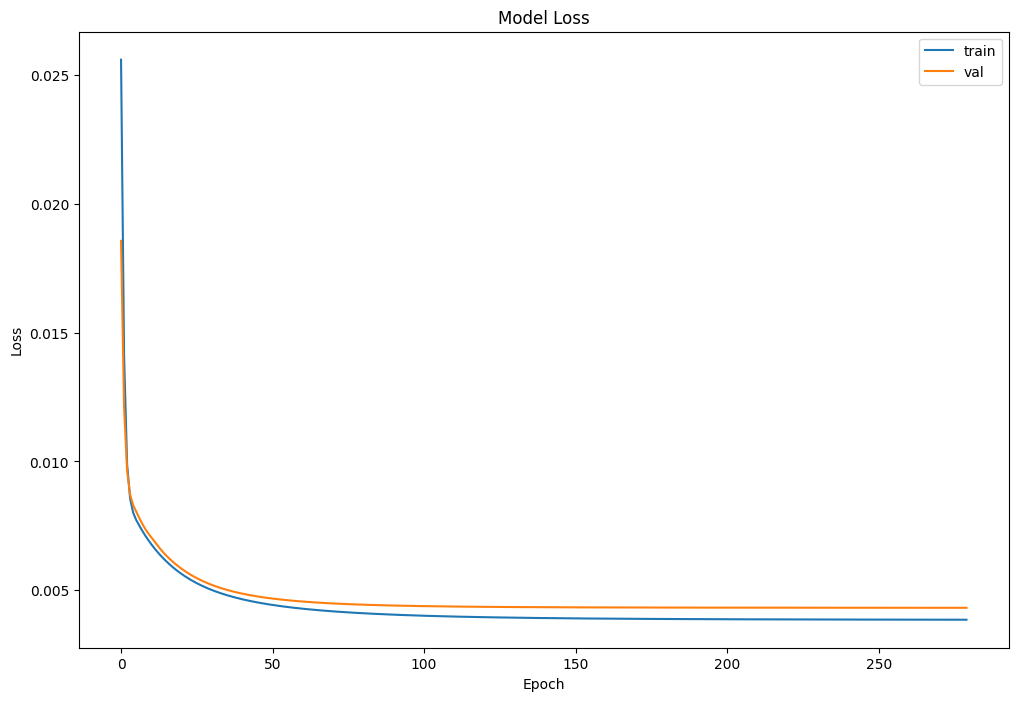

In [60]:
plt.figure(figsize=(12,8))

# 훈련 손실 그래프
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### test

In [77]:
import matplotlib.pyplot as plt
# 임의의 훈련 샘플 선택
sample_seq, sample_label = test_dataset[30]

DLinear_model.eval()
with torch.no_grad():
    sample_pred= DLinear_model(sample_seq.unsqueeze(-1).permute(2,0,1))
    sample_pred = torch.squeeze(sample_pred, dim=0).permute(1,0)

# 실제 값과 예측 값을 numpy 배열로 변환
sample_seq = sample_seq
sample_label = sample_label.numpy()
sample_pred = sample_pred.numpy()

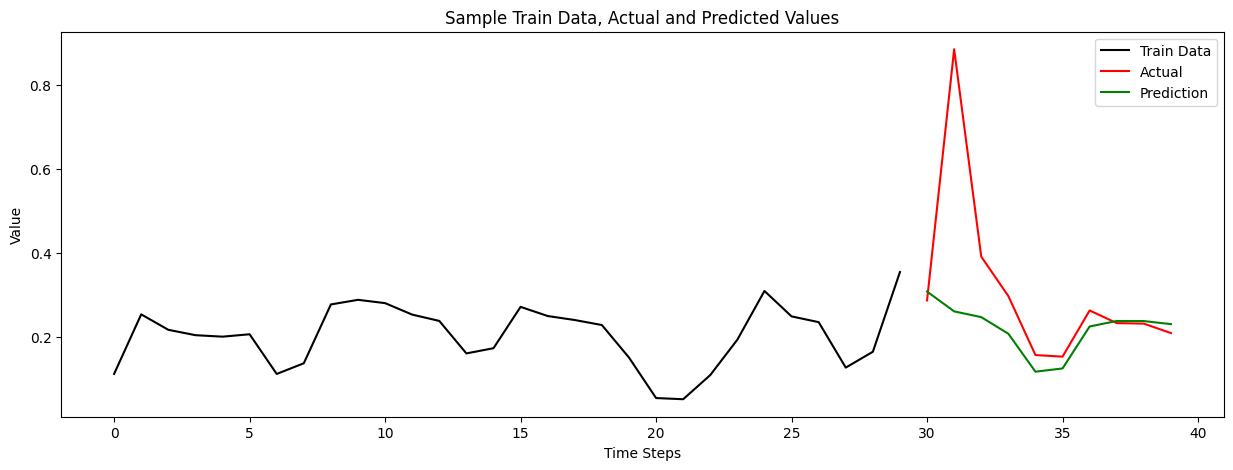

In [78]:
# 시각화
plt.figure(figsize=(15, 5))

# 훈련 데이터 부분 (노란색)
plt.plot(np.arange(len(sample_seq[0])), sample_seq[0], label='Train Data', color='black')

# 실제 레이블 부분 (빨간색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
actual_indices = np.arange(len(sample_seq[0]), len(sample_seq[0]) + len(sample_label[0]))
plt.plot(actual_indices, sample_label[0], label='Actual', color='red')

# 예측 부분 (초록색) — 마지막 훈련 데이터 포인트 다음에 위치해야 함
# 훈련 데이터 길이 + 예측 지점
pred_indices = np.arange(len(sample_seq[0]), len(sample_seq[0]) + len(sample_pred[0]))
plt.plot(pred_indices, sample_pred[0], label='Prediction', color='green')

plt.title('Sample Train Data, Actual and Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

In [41]:
DLinear_model.eval()
with torch.no_grad():
  for seq, labels in test_loader:
     y_pred  = DLinear_model(seq)
     val_loss = criterion(y_pred, labels)

  print(val_loss)

tensor(0.0146)
